In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# ---- Correct Kaggle installation cell ----
# Make sure we have all required packages for this notebook.

# Torch & torchvision are already included in Kaggle, so we skip reinstalling them.

!pip install --quiet timm scikit-learn pandas pillow tqdm
# pytorch-grad-cam (install latest compatible version)
!pip install --quiet git+https://github.com/jacobgil/pytorch-grad-cam.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installe

In [2]:
# Cell 2: 01_safe_csv_cleaning
import os, csv, numpy as np, sys
BASE = "/kaggle/input/chexpert"
SRC_CSV = os.path.join(BASE, "train.csv")
CLEAN_CSV = "/kaggle/working/chexpert_train_clean.csv"
OUT_RESOLVED = "/kaggle/working/chexpert_train_resolved.csv"

assert os.path.exists(SRC_CSV), f"Source CSV not found: {SRC_CSV}"

# 1) Write cleaned CSV (coerce all cells to simple strings)
with open(SRC_CSV, 'r', errors='replace') as fr, open(CLEAN_CSV, 'w', newline='') as fw:
    reader = csv.reader(fr)
    writer = csv.writer(fw)
    try:
        header = next(reader)
    except StopIteration:
        raise RuntimeError("Source CSV appears empty.")
    header = [str(h).strip() for h in header]
    writer.writerow(header)
    row_count = 0
    for r in reader:
        if len(r) < len(header):
            r = r + [''] * (len(header) - len(r))
        elif len(r) > len(header):
            r = r[:len(header)-1] + [",".join(r[len(header)-1:])]
        clean_row = []
        for cell in r:
            if cell is None:
                clean_row.append("")
            elif isinstance(cell, (list, tuple, np.ndarray)):
                clean_row.append(",".join(map(str, cell)))
            else:
                clean_row.append(str(cell))
        writer.writerow(clean_row)
        row_count += 1
print(f"Wrote cleaned CSV rows: {row_count} -> {CLEAN_CSV}")

# 2) Read cleaned CSV with csv.reader and resolve paths into absolute Kaggle paths
with open(CLEAN_CSV, 'r', newline='') as fr:
    reader = csv.reader(fr)
    header = next(reader)
    header = [h.strip() for h in header]
    records = []
    for r in reader:
        if len(r) < len(header):
            r = r + [''] * (len(header) - len(r))
        elif len(r) > len(header):
            r = r[:len(header)-1] + [",".join(r[len(header)-1:])]
        rec = {h: (r[i].strip() if r[i] != '' else None) for i,h in enumerate(header)}
        records.append(rec)
print("Parsed cleaned CSV rows:", len(records))
img_col = None
for c in header:
    if c.lower() in ("path","image","image_path","filename"):
        img_col = c; break
if img_col is None:
    img_col = header[0]
print("Detected image column:", img_col)

def normalize_path(s):
    if s is None:
        return None
    s = str(s).strip()
    if s == "":
        return None
    b = os.path.basename(s)
    if b.startswith("._"):
        return None
    if os.path.isabs(s) and os.path.exists(s):
        return s
    for marker in ("train/", "valid/"):
        idx = s.find(marker)
        if idx != -1:
            candidate = os.path.join(BASE, s[idx:])
            if os.path.exists(candidate):
                return candidate
    prefix = "CheXpert-v1.0-small/"
    if s.startswith(prefix):
        cand = os.path.join(BASE, s[len(prefix):])
        if os.path.exists(cand):
            return cand
    cand2 = os.path.join(BASE, s)
    if os.path.exists(cand2):
        return cand2
    # search fallback
    for root_sub in ("train","valid"):
        for root, dirs, files in os.walk(os.path.join(BASE, root_sub)):
            if b in files:
                return os.path.join(root, b)
    return None

resolved_count = 0
resolved_examples = []
unresolved_examples = []
for rec in records:
    raw = rec.get(img_col)
    rp = normalize_path(raw)
    rec['resolved_path'] = rp
    if rp is not None:
        resolved_count += 1
        if len(resolved_examples) < 8:
            resolved_examples.append(rp)
    else:
        if len(unresolved_examples) < 8:
            unresolved_examples.append(raw)

total = len(records)
print(f"Resolved paths: {resolved_count} / {total}")

# write final resolved CSV
out_header = header + ["resolved_path"]
with open(OUT_RESOLVED, 'w', newline='') as fw:
    writer = csv.writer(fw)
    writer.writerow(out_header)
    for rec in records:
        row = [rec.get(h, "") if rec.get(h, None) is not None else "" for h in header]
        row.append(rec.get('resolved_path') or "")
        writer.writerow(row)
print("Saved final resolved CSV to:", OUT_RESOLVED)

# Print some samples
print("\nSample resolved paths:")
for p in resolved_examples[:8]:
    print(" -", p)
if unresolved_examples:
    print("\nSample unresolved (if any):")
    for s in unresolved_examples[:8]:
        print(" -", s)

Wrote cleaned CSV rows: 223414 -> /kaggle/working/chexpert_train_clean.csv
Parsed cleaned CSV rows: 223414
Detected image column: Path
Resolved paths: 223414 / 223414
Saved final resolved CSV to: /kaggle/working/chexpert_train_resolved.csv

Sample resolved paths:
 - /kaggle/input/chexpert/train/patient00001/study1/view1_frontal.jpg
 - /kaggle/input/chexpert/train/patient00002/study2/view1_frontal.jpg
 - /kaggle/input/chexpert/train/patient00002/study1/view1_frontal.jpg
 - /kaggle/input/chexpert/train/patient00002/study1/view2_lateral.jpg
 - /kaggle/input/chexpert/train/patient00003/study1/view1_frontal.jpg
 - /kaggle/input/chexpert/train/patient00004/study1/view1_frontal.jpg
 - /kaggle/input/chexpert/train/patient00004/study1/view2_lateral.jpg
 - /kaggle/input/chexpert/train/patient00005/study1/view1_frontal.jpg


In [3]:
# Cell 3: 02_configs
WORKING_RESOLVED_CSV = "/kaggle/working/chexpert_train_resolved.csv"  # created above
assert os.path.exists(WORKING_RESOLVED_CSV), "Resolved CSV missing; run Cell 2."

# Label list from CheXpert CSV header (edit if you prefer a subset)
LABELS = ["No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity",
          "Lung Lesion","Edema","Consolidation","Pneumonia","Atelectasis",
          "Pneumothorax","Pleural Effusion","Pleural Other","Fracture","Support Devices"]

IMAGE_COL = "resolved_path"
IMAGE_SIZE = 320
BATCH_SIZE = 16
NUM_WORKERS = 2
LR = 1e-4
EPOCHS = 2      # small by default for quick runs
DEVICE = "cuda"

# Continual learning params
N_TASKS = 4
EXEMPLAR_BUDGET = 1000
EXEMPLARS_PER_BATCH = 8
USE_EWC = True
EWC_LAMBDA = 1000.0
FISHER_SAMPLES = 200

print("Config OK. Resolved CSV:", WORKING_RESOLVED_CSV)
print("Labels len:", len(LABELS))


Config OK. Resolved CSV: /kaggle/working/chexpert_train_resolved.csv
Labels len: 14


In [4]:
# Cell 4: 03_imports_and_device
import math, random, time
from PIL import Image
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() and DEVICE == "cuda" else "cpu")
print("Device:", DEVICE)


Device: cuda


In [5]:
# Cell 5_repl: 04_load_and_split_no_pandas
# Load resolved CSV using csv.reader into pure-Python records, then create train/val splits.
import csv, random, math, os
from pprint import pprint

RESOLVED_CSV = "/kaggle/working/chexpert_train_resolved.csv"
assert os.path.exists(RESOLVED_CSV), f"Resolved CSV not found: {RESOLVED_CSV}"

# Read with csv.reader
with open(RESOLVED_CSV, 'r', newline='') as fr:
    reader = csv.reader(fr)
    header = next(reader)
    header = [h.strip() for h in header]
    records = []
    for r in reader:
        if len(r) < len(header):
            r = r + [''] * (len(header) - len(r))
        elif len(r) > len(header):
            r = r[:len(header)-1] + [",".join(r[len(header)-1:])]
        rec = {h: (r[i].strip() if r[i] != '' else None) for i,h in enumerate(header)}
        records.append(rec)

print("Loaded resolved CSV rows:", len(records))
print("Columns sample (first 12):", header[:12])
# Show sample record keys
pprint(records[0], depth=1)

# Ensure LABELS exist; coerce label strings to floats or None
for rec in records:
    for lab in LABELS:
        v = rec.get(lab, None)
        if v is None or v == "":
            rec[lab] = None
        else:
            try:
                rec[lab] = float(v)
            except:
                # fallback: try removing stray characters
                try:
                    rec[lab] = float(v.replace(',', '').strip())
                except:
                    rec[lab] = None

# Shuffle & split indices into train/val (same split ratio as before: 88% train)
random.seed(SEED)
indices = list(range(len(records)))
random.shuffle(indices)
split = int(len(indices) * 0.88)
train_idx = indices[:split]
val_idx = indices[split:]
train_records = [records[i] for i in train_idx]
val_records = [records[i] for i in val_idx]

print("Train records:", len(train_records), "Val records:", len(val_records))
# quick sanity show
print("Sample train resolved_path:", train_records[0].get(IMAGE_COL))


Loaded resolved CSV rows: 223414
Columns sample (first 12): ['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation']
{'AP/PA': 'AP',
 'Age': '68',
 'Atelectasis': None,
 'Cardiomegaly': None,
 'Consolidation': None,
 'Edema': None,
 'Enlarged Cardiomediastinum': None,
 'Fracture': None,
 'Frontal/Lateral': 'Frontal',
 'Lung Lesion': None,
 'Lung Opacity': None,
 'No Finding': '1.0',
 'Path': 'CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg',
 'Pleural Effusion': None,
 'Pleural Other': None,
 'Pneumonia': None,
 'Pneumothorax': '0.0',
 'Sex': 'Female',
 'Support Devices': '1.0',
 'resolved_path': '/kaggle/input/chexpert/train/patient00001/study1/view1_frontal.jpg'}
Train records: 196604 Val records: 26810
Sample train resolved_path: /kaggle/input/chexpert/train/patient13747/study12/view1_frontal.jpg


In [6]:
# REPLACEMENT: dataset cell that avoids torch.from_numpy completely
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image

def pil_to_tensor_safe(pil_img, image_size=IMAGE_SIZE):
    # Resize
    if pil_img.mode != "RGB":
        pil_img = pil_img.convert("RGB")
    pil_img = pil_img.resize((image_size, image_size), resample=Image.BILINEAR)
    arr = np.asarray(pil_img, dtype=np.uint8)
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)
    arr = arr.astype(np.float32) / 255.0
    mean = np.array([0.485, 0.485, 0.485], dtype=np.float32)
    std = np.array([0.229, 0.229, 0.229], dtype=np.float32)
    arr = (arr - mean) / std
    arr = np.transpose(arr, (2,0,1)).copy()   # CHW
    # Convert to plain nested lists to avoid numpy->torch ufunc mismatch
    arr_list = arr.tolist()
    tensor = torch.tensor(arr_list, dtype=torch.float32)
    return tensor

class CXRRecordsDatasetSafe(Dataset):
    def __init__(self, records, image_col=IMAGE_COL, label_cols=LABELS, image_size=IMAGE_SIZE):
        self.records = records
        self.image_col = image_col
        self.label_cols = label_cols
        self.image_size = image_size

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        rec = self.records[idx]
        path = rec.get(self.image_col)
        if path is None:
            raise RuntimeError(f"Record {idx} missing image path.")
        with Image.open(path) as img:
            img = img.convert("RGB")
            tensor = pil_to_tensor_safe(img, image_size=self.image_size)
        labels = []
        mask = []
        for c in self.label_cols:
            v = rec.get(c, None)
            if v is None or (isinstance(v, float) and np.isnan(v)):
                labels.append(0.0); mask.append(0.0)
            else:
                labels.append(float(v)); mask.append(1.0)
        labels = torch.tensor(labels, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        return tensor, labels, mask, path

# Quick loader test
sample_recs = train_records[:32]
ds = CXRRecordsDatasetSafe(sample_recs)
loader = DataLoader(ds, batch_size=4, shuffle=False, num_workers=0)
for imgs, labs, masks, paths in loader:
    print("Batch imgs", imgs.shape, "labs", labs.shape)
    break


Batch imgs torch.Size([4, 3, 320, 320]) labs torch.Size([4, 14])


In [7]:
# Cell 7_repl: 06_model_utils  (unchanged)
def get_densenet(num_labels=len(LABELS), pretrained=True):
    model = models.densenet121(pretrained=pretrained)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_labels)
    return model

def expand_classifier_head(model, new_num_labels):
    old = model.classifier
    old_out = old.out_features
    in_f = old.in_features
    new_layer = nn.Linear(in_f, new_num_labels)
    with torch.no_grad():
        new_layer.weight[:old_out, :] = old.weight
        new_layer.bias[:old_out] = old.bias
    model.classifier = new_layer


In [8]:
# Cell 8_repl: 07_exemplar_buffer  (unchanged)
class ExemplarBuffer:
    def __init__(self, budget:int):
        self.budget = budget
        self.paths = []
        self.labels = []

    def __len__(self):
        return len(self.paths)

    def add(self, paths:list, labels:list):
        for p, l in zip(paths, labels):
            self.paths.append(p)
            self.labels.append(np.array(l, dtype=np.float32))
        self._prune()

    def _prune(self):
        while len(self.paths) > self.budget:
            self.paths.pop(0)
            self.labels.pop(0)

    def sample(self, k:int):
        if len(self.paths) == 0:
            return [], []
        k = min(k, len(self.paths))
        idx = np.random.choice(len(self.paths), k, replace=False)
        return [self.paths[i] for i in idx], [self.labels[i] for i in idx]


In [9]:
# Cell 9_repl: 08_ewc  (unchanged)
def compute_fisher(model, dataloader, device, samples=200):
    model.eval()
    fisher = {}
    for n,p in model.named_parameters():
        if p.requires_grad:
            fisher[n] = torch.zeros_like(p.data).to(device)
    cnt = 0
    for imgs, labels, masks, _ in dataloader:
        imgs = imgs.to(device); labels = labels.to(device)
        model.zero_grad()
        outputs = model(imgs)
        loss = F.binary_cross_entropy_with_logits(outputs, labels, reduction='sum')
        loss.backward()
        for n,p in model.named_parameters():
            if p.requires_grad and p.grad is not None:
                fisher[n] += (p.grad.data ** 2)
        cnt += imgs.size(0)
        if cnt >= samples:
            break
    for n in fisher:
        fisher[n] /= max(1.0, float(cnt))
    return fisher

def ewc_penalty(model, fisher, old_params, lambda_ewc):
    loss = 0.0
    for n,p in model.named_parameters():
        if n in fisher:
            loss = loss + (fisher[n] * (p - old_params[n]).pow(2)).sum()
    return lambda_ewc * loss


In [10]:
# Cell 10_repl: 09_training_utils_no_pandas
def train_one_epoch(model, optimizer, dataloader, exemplar_buffer, device, ewc_fisher=None, old_params=None):
    model.train()
    total_loss = 0.0
    for imgs, labels, masks, _ in tqdm(dataloader, desc="Train"):
        imgs = imgs.to(device); labels = labels.to(device); masks = masks.to(device)
        ex_paths, ex_labels = exemplar_buffer.sample(EXEMPLARS_PER_BATCH)
        if len(ex_paths) > 0:
            ex_tensors = []
            ex_lbls = []
            for p, lab in zip(ex_paths, ex_labels):
                img_p = Image.open(p).convert("RGB")
                img_p = transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))(img_p)
                img_p = transforms.ToTensor()(img_p)
                img_p = transforms.Normalize([0.485,0.485,0.485],[0.229,0.229,0.229])(img_p)
                ex_tensors.append(img_p)
                ex_lbls.append(torch.from_numpy(lab))
            ex_tensors = torch.stack(ex_tensors).to(device)
            ex_lbls = torch.stack(ex_lbls).to(device)
            imgs = torch.cat([imgs, ex_tensors], dim=0)
            labels = torch.cat([labels, ex_lbls], dim=0)
            masks = torch.cat([masks, torch.ones_like(ex_lbls)], dim=0)

        optimizer.zero_grad()
        outputs = model(imgs)
        bce = F.binary_cross_entropy_with_logits(outputs, labels, reduction='none')
        bce = (bce * masks).sum() / (masks.sum().clamp_min(1.0))
        loss = bce
        if ewc_fisher is not None and old_params is not None:
            loss = loss + ewc_penalty(model, ewc_fisher, old_params, EWC_LAMBDA)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# pure-numpy AUC (no sklearn)
def _auc_from_ranks(y_true, y_score):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    n_pos = int(np.sum(y_true == 1))
    n_neg = int(np.sum(y_true == 0))
    if n_pos == 0 or n_neg == 0:
        return float('nan')
    order = np.argsort(y_score)
    ranks = np.empty_like(order, dtype=float)
    sorted_scores = y_score[order]
    i = 0; rank = 1; N = len(y_score)
    while i < N:
        j = i+1
        while j < N and sorted_scores[j] == sorted_scores[i]:
            j += 1
        avg_rank = (rank + (rank + (j - i) - 1)) / 2.0
        ranks[i:j] = avg_rank
        rank += (j - i)
        i = j
    inv_ranks = np.empty_like(ranks)
    inv_ranks[order] = ranks
    sum_ranks_pos = np.sum(inv_ranks[y_true == 1])
    auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2.0) / (n_pos * n_neg)
    return float(auc)

def evaluate_auroc(model, dataloader, device, label_cols):
    model.eval()
    preds_list = []; targets_list = []
    with torch.no_grad():
        for imgs, labels, masks, _ in tqdm(dataloader, desc="Eval"):
            imgs = imgs.to(device)
            out = torch.sigmoid(model(imgs)).detach().cpu().numpy()
            preds_list.append(out)
            targets_list.append(labels.numpy())
    if len(preds_list) == 0:
        return {lab: float('nan') for lab in label_cols}, float('nan')
    preds = np.vstack(preds_list)
    targets = np.vstack(targets_list)
    aucs = {}
    for i, lab in enumerate(label_cols):
        y_true = targets[:, i]
        if len(np.unique(y_true[~np.isnan(y_true)])) < 2:
            aucs[lab] = float('nan'); continue
        y_bin = (y_true >= 0.5).astype(int)
        s = preds[:, i]
        try:
            a = _auc_from_ranks(y_bin, s)
            aucs[lab] = a
        except:
            aucs[lab] = float('nan')
    vals = [v for v in aucs.values() if not np.isnan(v)]
    mean_auc = float(np.mean(vals)) if len(vals) > 0 else float('nan')
    return aucs, mean_auc


In [11]:
# Cell 11_repl: 10_gradcam_and_report  (unchanged)
def make_gradcam_visual(model, pil_img, device):
    try:
        from pytorch_grad_cam import GradCAM
        from pytorch_grad_cam.utils.image import show_cam_on_image
    except Exception as e:
        print("pytorch-grad-cam import failed:", e)
        return None
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.485,0.485],[0.229,0.229,0.229])
    ])
    inp = transform(pil_img).unsqueeze(0).to(device)
    target_layers = [model.features.denseblock4] if hasattr(model, 'features') else [list(model.children())[-2]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=(device.type=='cuda'))
    grayscale_cam = cam(input_tensor=inp, targets=None)
    np_img = np.array(pil_img.resize((IMAGE_SIZE, IMAGE_SIZE))).astype(np.float32)/255.0
    vis = show_cam_on_image(np_img, grayscale_cam[0], use_rgb=True)
    from PIL import Image as PILImage
    return PILImage.fromarray(vis)

def build_report_from_preds(preds: dict):
    findings = []
    for k,v in preds.items():
        if v > 0.20:
            findings.append(f"- {k}: approx {int(round(v*100))}%")
    if not findings:
        findings = ["No acute cardiopulmonary disease detected with high probability."]
    prompt = f"""You are a radiology assistant. Produce a concise chest X-ray report with sections: Exam, Findings, Impression.
Exam: Chest radiograph (frontal). Findings:
{chr(10).join(findings)}

Impression:
- Summarize the findings above using cautious language and recommend radiologist review.
"""
    return prompt


In [12]:
# REPLACE dataset with safe version and helper functions
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Safe PIL -> torch.tensor conversion that avoids torch.from_numpy path
def pil_to_tensor_safe(pil_img, image_size=IMAGE_SIZE):
    if pil_img.mode != "RGB":
        pil_img = pil_img.convert("RGB")
    pil_img = pil_img.resize((image_size, image_size), resample=Image.BILINEAR)
    arr = np.asarray(pil_img, dtype=np.uint8)
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)
    arr = arr.astype(np.float32) / 255.0
    mean = np.array([0.485, 0.485, 0.485], dtype=np.float32)
    std  = np.array([0.229, 0.229, 0.229], dtype=np.float32)
    arr = (arr - mean) / std
    arr = np.transpose(arr, (2,0,1)).copy()   # CHW
    # Convert to plain nested lists then to torch.tensor (robust)
    arr_list = arr.tolist()
    tensor = torch.tensor(arr_list, dtype=torch.float32)
    return tensor

# Safe dataset that returns tensors prepared with pil_to_tensor_safe
class CXRRecordsDatasetSafe(Dataset):
    def __init__(self, records, image_col=IMAGE_COL, label_cols=LABELS, image_size=IMAGE_SIZE):
        self.records = records
        self.image_col = image_col
        self.label_cols = label_cols
        self.image_size = image_size

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        rec = self.records[idx]
        path = rec.get(self.image_col)
        if path is None:
            raise RuntimeError(f"Record {idx} missing image path.")
        # open and convert
        with Image.open(path) as img:
            img = img.convert("RGB")
            tensor = pil_to_tensor_safe(img, image_size=self.image_size)
        labels = []
        mask = []
        for c in self.label_cols:
            v = rec.get(c, None)
            if v is None or (isinstance(v, float) and np.isnan(v)):
                labels.append(0.0); mask.append(0.0)
            else:
                labels.append(float(v)); mask.append(1.0)
        labels = torch.tensor(labels, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        return tensor, labels, mask, path

# Quick sanity check (small batch)
sample_recs = train_records[:8]
ds_test = CXRRecordsDatasetSafe(sample_recs)
loader_test = DataLoader(ds_test, batch_size=2, shuffle=False, num_workers=0)
for imgs, labs, masks, paths in loader_test:
    print("Sanity batch shapes:", imgs.shape, labs.shape)
    break


Sanity batch shapes: torch.Size([2, 3, 320, 320]) torch.Size([2, 14])


In [13]:
# ===== GUARANTEED-FAST SMOKE TEST (paste & run) =====
# 1) If your kernel is still running, interrupt it, then run this cell.
# 2) This will use a small subset and cap steps per epoch to ensure it's quick.

import os, random, time
import numpy as np
from PIL import Image
import torch, torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn

# ---------- FAST debug CONFIG (edit if needed) ----------
FAST_NUM_SAMPLES = 800        # small number -> very fast
BATCH_SIZE = 16               # larger batch => fewer steps
IMAGE_SIZE = 128              # smaller image => faster per-step
MAX_STEPS_PER_EPOCH = 100     # cap steps per epoch
TEST_EPOCHS = 1
TEST_EXEMPLAR_BUDGET = 10
TEST_EXEMPLARS_PER_BATCH = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ---------- safe pil->tensor (same as before) ----------
def pil_to_tensor_safe(pil_img, image_size=IMAGE_SIZE):
    if pil_img.mode != "RGB":
        pil_img = pil_img.convert("RGB")
    pil_img = pil_img.resize((image_size, image_size), resample=Image.BILINEAR)
    arr = np.asarray(pil_img, dtype=np.uint8)
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)
    arr = arr.astype(np.float32) / 255.0
    mean = np.array([0.485,0.485,0.485], dtype=np.float32)
    std  = np.array([0.229,0.229,0.229], dtype=np.float32)
    arr = (arr - mean) / std
    arr = np.transpose(arr, (2,0,1)).copy()
    return torch.tensor(arr.tolist(), dtype=torch.float32)

# ---------- load a small subset safely (use resolved CSV if exist) ----------
def load_resolved_csv(path="/kaggle/working/chexpert_train_resolved_fast.csv", max_rows=None):
    import csv
    recs = []
    if not os.path.exists(path):
        raise RuntimeError(f"Resolved CSV not found at {path}. Run CSV-cleaning cell first.")
    with open(path,'r',newline='') as fr:
        rdr = csv.reader(fr)
        hdr = next(rdr)
        for i,r in enumerate(rdr):
            if max_rows is not None and i >= max_rows: break
            if len(r) < len(hdr): r = r + [''] * (len(hdr) - len(r))
            rec = {hdr[j]: (r[j].strip() if r[j] != '' else None) for j in range(len(hdr))}
            if 'resolved_path' not in rec or not rec['resolved_path']:
                rec['resolved_path'] = rec.get('Path')
            recs.append(rec)
    return recs

# Try to obtain records; prefer preloaded train_records if present but we will slice it down
if 'train_records' in globals():
    all_recs = train_records
    print("Using existing train_records (will sample FAST_NUM_SAMPLES from it).")
else:
    all_recs = load_resolved_csv(max_rows=FAST_NUM_SAMPLES*2)  # read minimal rows
    print("Loaded records from resolved CSV.")

# Choose a small random subset to be fast and reproducible
random.seed(42)
if len(all_recs) > FAST_NUM_SAMPLES:
    sample_recs = random.sample(all_recs, FAST_NUM_SAMPLES)
else:
    sample_recs = all_recs

# ---------- Dataset class (small robust) ----------
class SmallCXRDataset(torch.utils.data.Dataset):
    def __init__(self, records, image_col="resolved_path", image_size=IMAGE_SIZE):
        self.records = records
        self.image_col = image_col
        self.image_size = image_size
    def __len__(self): return len(self.records)
    def __getitem__(self, idx):
        rec = self.records[idx]
        p = rec.get(self.image_col)
        if not p:
            raise RuntimeError(f"Missing path at idx {idx}")
        with Image.open(p) as im:
            im = im.convert("RGB")
            t = pil_to_tensor_safe(im, image_size=self.image_size)
        # Build label vector robustly: convert known numeric columns, handle -1 -> masked
        labels = []
        possible = [k for k in rec.keys() if k not in ("Path","resolved_path","Sex","Age","Frontal/Lateral","AP/PA")]
        for k in possible:
            v = rec.get(k)
            try:
                labels.append(float(v) if v not in (None,"") else 0.0)
            except:
                pass
        if len(labels) == 0:
            labels = [0.0]*14
        labels = np.array(labels, dtype=np.float32)
        # If CheXpert uses -1 for uncertain, mask them out
        mask = np.ones_like(labels, dtype=np.float32)
        mask[labels == -1.0] = 0.0
        labels[labels == -1.0] = 0.0
        return t, torch.tensor(labels, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32), p

# ---------- DataLoader ----------
ds = SmallCXRDataset(sample_recs, image_size=IMAGE_SIZE)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# ---------- Build model with correct num labels ----------
# infer num labels from first sample
_, lab0, _, _ = ds[0]
NUM_LABELS = lab0.numel()
print("NUM_LABELS inferred:", NUM_LABELS)

def small_model(num_labels):
    m = models.resnet18(pretrained=True)
    m.fc = nn.Linear(m.fc.in_features, num_labels)
    return m

model = small_model(NUM_LABELS).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

# ---------- Small exemplar buffer ----------
class ExBuf:
    def __init__(self, budget):
        self.paths=[]; self.labels=[]; self.tensors=[]
        self.budget=budget
    def add(self, paths, labels, image_size=IMAGE_SIZE):
        for p,l in zip(paths, labels):
            self.paths.append(p); self.labels.append(np.array(l,dtype=np.float32))
            with Image.open(p) as im:
                tt = pil_to_tensor_safe(im, image_size=image_size)
            self.tensors.append(tt.cpu())
        while len(self.paths)>self.budget:
            self.paths.pop(0); self.labels.pop(0); self.tensors.pop(0)
    def sample_as_batch(self,k,device='cpu'):
        if len(self.paths)==0: return None,None
        k=min(k,len(self.paths)); idx=np.random.choice(len(self.paths),k,replace=False)
        proc=[]; labs=[]
        for i in idx:
            proc.append(self.tensors[i])
            labs.append(self.labels[i])
        return torch.stack(proc).to(device), torch.tensor([np.array(x) for x in labs],dtype=torch.float32).to(device)

exbuf = ExBuf(TEST_EXEMPLAR_BUDGET)

# ---------- TRAIN (bounded steps) ----------
print("Starting FAST smoke test: samples", len(sample_recs))
model.train()
global_step = 0
for epoch in range(TEST_EPOCHS):
    step = 0
    for imgs, labels, masks, paths in loader:
        step += 1; global_step += 1
        imgs = imgs.to(DEVICE); labels = labels.to(DEVICE); masks = masks.to(DEVICE)
        ex_t, ex_l = exbuf.sample_as_batch(TEST_EXEMPLARS_PER_BATCH, device=DEVICE)
        if ex_t is not None:
            imgs = torch.cat([imgs, ex_t], dim=0)
            labels = torch.cat([labels, ex_l], dim=0)
            masks = torch.cat([masks, torch.ones_like(ex_l)], dim=0)
        opt.zero_grad()
        out = model(imgs)
        if out.shape != labels.shape:
            raise RuntimeError(f"Output shape {out.shape} != labels {labels.shape}")
        bce = F.binary_cross_entropy_with_logits(out, labels, reduction='none')
        loss = (bce * masks).sum() / (masks.sum().clamp_min(1.0))
        loss.backward(); opt.step()
        if step % 5 == 0:
            print(f"Epoch {epoch+1} step {step}, loss {loss.item():.4f}")
        if MAX_STEPS_PER_EPOCH is not None and step >= MAX_STEPS_PER_EPOCH:
            print(f"Reached MAX_STEPS_PER_EPOCH={MAX_STEPS_PER_EPOCH}, breaking epoch early.")
            break
    # add small exemplars from this subset
    k = min(TEST_EXEMPLAR_BUDGET, len(sample_recs))
    sample_recs_small = random.sample(sample_recs, k)
    imgs_to_add = [r.get("resolved_path") for r in sample_recs_small]
    labs = [[0.0]*NUM_LABELS for _ in imgs_to_add]
    exbuf.add(imgs_to_add, labs, image_size=IMAGE_SIZE)

print("FAST smoke test finished. global_step:", global_step)


Device: cuda
Using existing train_records (will sample FAST_NUM_SAMPLES from it).
NUM_LABELS inferred: 14


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s] 


Starting FAST smoke test: samples 800
Epoch 1 step 5, loss 0.4488
Epoch 1 step 10, loss 0.3896
Epoch 1 step 15, loss 0.3694
Epoch 1 step 20, loss 0.4342
Epoch 1 step 25, loss 0.3679
Epoch 1 step 30, loss 0.4236
Epoch 1 step 35, loss 0.3796
Epoch 1 step 40, loss 0.3983
Epoch 1 step 45, loss 0.2977
Epoch 1 step 50, loss 0.3144
FAST smoke test finished. global_step: 50


In [ ]:
####THIS IS THE FINAL CODE FOR THE WHOLE DATASET BUT I AM JUST CREATING A BASE MODEL FOR FUTURE IMPLEMENTAION

In [14]:
# Cell: INCREMENTAL_DATA_PREP
# CONFIG (edit paths)
MASTER_RESOLVED_CSV = "/kaggle/working/chexpert_train_resolved.csv"  # master resolved CSV used by training
NEW_FOLDER = None      # e.g. "/kaggle/input/my_new_chexpert_chunk" or None
NEW_RESOLVED_CSV = None # e.g. "/kaggle/working/new_chunk_resolved.csv" if you already have a resolved CSV to ingest
APPEND_TO_MASTER = True
CREATE_TASK_SPLITS = True
N_TASKS = 4
OUT_TASK_SPLIT_JSON = "/kaggle/working/task_splits.json"

import csv, os, json

def get_files_under(root, allow_exts=(".jpg",".jpeg",".png")):
    out = []
    for d,_,files in os.walk(root):
        for f in files:
            if f.lower().endswith(allow_exts):
                out.append(os.path.join(d,f))
    return out

def make_records_from_folder(folder):
    """Return list of record dicts: {'resolved_path':abs, 'Path':relative_like, ...}"""
    files = get_files_under(folder)
    recs = []
    for p in files:
        # Try to produce a CSV-style Path similar to CheXpert CSV format:
        rel = os.path.relpath(p, start=folder).replace(os.path.sep, "/")
        fake_path = os.path.basename(folder).rstrip("/") + "/" + rel
        recs.append({"Path": fake_path, "resolved_path": p})
    return recs

def read_resolved_csv_as_records(path):
    recs = []
    with open(path,'r',newline='') as fr:
        rdr = csv.reader(fr)
        hdr = next(rdr)
        for r in rdr:
            if len(r) < len(hdr):
                r = r + ['']*(len(hdr)-len(r))
            rec = {hdr[i]: (r[i].strip() if r[i] != '' else None) for i in range(len(hdr))}
            if 'resolved_path' not in rec or not rec['resolved_path']:
                rec['resolved_path'] = rec.get('Path')
            recs.append(rec)
    return recs

def append_records_to_master(new_recs, master_csv=MASTER_RESOLVED_CSV):
    # append rows to master (preserves header)
    if not os.path.exists(master_csv):
        # create master by writing header keys from first rec
        hdr = list(new_recs[0].keys())
        with open(master_csv, 'w', newline='') as fw:
            w = csv.writer(fw)
            w.writerow(hdr)
            for r in new_recs:
                row = [r.get(h, "") for h in hdr]
                w.writerow(row)
        return
    # master exists -> read header, append rows matching header order (fill missing)
    with open(master_csv, 'r', newline='') as fr:
        rdr = csv.reader(fr)
        master_hdr = next(rdr)
    with open(master_csv, 'a', newline='') as fw:
        w = csv.writer(fw)
        for r in new_recs:
            row = [r.get(h, "") for h in master_hdr]
            w.writerow(row)

def create_task_splits(master_csv=MASTER_RESOLVED_CSV, n_tasks=N_TASKS, out_json=OUT_TASK_SPLIT_JSON):
    recs = read_resolved_csv_as_records(master_csv)
    random.shuffle(recs)
    splits = [ [] for _ in range(n_tasks) ]
    for i, r in enumerate(recs):
        splits[i % n_tasks].append(r)
    # write small manifest (only Path/resolved_path per task)
    manifest = { f"task_{i+1}": [ {"Path": rr.get("Path"), "resolved_path": rr.get("resolved_path")} for rr in splits[i] ] for i in range(n_tasks) }
    with open(out_json, 'w') as fw:
        json.dump(manifest, fw)
    print(f"Created {n_tasks} task splits and saved manifest -> {out_json}")
    return manifest

# ----- MAIN logic -----
new_records = []
if NEW_FOLDER:
    if not os.path.exists(NEW_FOLDER):
        raise FileNotFoundError(f"NEW_FOLDER not found: {NEW_FOLDER}")
    print("Scanning NEW_FOLDER for images...")
    new_records = make_records_from_folder(NEW_FOLDER)
    print("Found", len(new_records), "images in new folder.")
elif NEW_RESOLVED_CSV:
    print("Loading new resolved CSV:", NEW_RESOLVED_CSV)
    new_records = read_resolved_csv_as_records(NEW_RESOLVED_CSV)
    print("Loaded", len(new_records), "records from new resolved CSV.")
else:
    print("No NEW_FOLDER or NEW_RESOLVED_CSV specified. To create incremental dataset, set one of them and re-run.")
    new_records = []

# append to master resolved CSV
if APPEND_TO_MASTER and new_records:
    print("Appending new records to master resolved CSV...")
    append_records_to_master(new_records, MASTER_RESOLVED_CSV)
    print("Appended", len(new_records), "records to", MASTER_RESOLVED_CSV)

# create task splits manifest (optional)
if CREATE_TASK_SPLITS:
    if not os.path.exists(MASTER_RESOLVED_CSV):
        raise FileNotFoundError(f"Master CSV not found: {MASTER_RESOLVED_CSV}")
    manifest = create_task_splits(MASTER_RESOLVED_CSV, n_tasks=N_TASKS)
    print("Task splits created. Example sizes:", {k: len(v) for k,v in manifest.items()})
else:
    print("Skipping task split creation.")


No NEW_FOLDER or NEW_RESOLVED_CSV specified. To create incremental dataset, set one of them and re-run.
Created 4 task splits and saved manifest -> /kaggle/working/task_splits.json
Task splits created. Example sizes: {'task_1': 55854, 'task_2': 55854, 'task_3': 55853, 'task_4': 55853}


In [22]:
# CELL: DEFINE_EXEMPLAR_AND_EWC_HELPERS
# Re-defines ExemplarBufferCached, compute_fisher, and ewc_penalty used by the final training cell.

import os, random, math, time
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader

# ---------- Exemplar buffer (robust, caches tensors lazily) ----------
class ExemplarBufferCached:
    def __init__(self, capacity):
        self.capacity = int(capacity)
        self.paths = []    # list[str]
        self.labels = []   # list[list[float]] or list[tensor]
        self._cache = None # cached tensor batch (rebuild when needed)

    def __len__(self):
        return len(self.paths)

    def clear_cache(self):
        self._cache = None

    def add(self, paths, labels, image_size=224, cache_tensors=True):
        # trim if exceeding capacity (FIFO)
        n_new = len(paths)
        if len(self.paths) + n_new > self.capacity:
            extra = len(self.paths) + n_new - self.capacity
            # drop oldest
            self.paths = self.paths[extra:]
            self.labels = self.labels[extra:]
        self.paths.extend(paths)
        self.labels.extend(labels)
        if cache_tensors:
            self.clear_cache()

    def sample_as_batch(self, n, device):
        if len(self.paths) == 0:
            return None, None
        n = min(n, len(self.paths))
        idxs = random.sample(range(len(self.paths)), n)
        imgs = []
        labs = []
        for i in idxs:
            p = self.paths[i]
            lab = self.labels[i]
            # read image, convert to tensor (use PIL)
            with Image.open(p) as im:
                im = im.convert("RGB")
                im = im.resize((224,224))
                arr = np.asarray(im, dtype=np.float32)/255.0
                if arr.ndim == 2:
                    arr = np.stack([arr]*3, -1)
                arr = (arr - np.array([0.485,0.485,0.485]))/np.array([0.229,0.229,0.229])
                arr = np.transpose(arr, (2,0,1)).copy()
                imgs.append(torch.tensor(arr, dtype=torch.float32))
            # label: accept numpy/list/tensor
            if isinstance(lab, torch.Tensor):
                labs.append(lab.clone().float())
            else:
                labs.append(torch.tensor(lab, dtype=torch.float32))
        imgs = torch.stack(imgs).to(device)
        labs = torch.stack(labs).to(device)
        return imgs, labs

# ---------- Fisher computation for EWC ----------
def compute_fisher(model, dataloader, device, samples=200):
    """
    Approximate diagonal Fisher information for parameters in model (only for params with requires_grad=True).
    Returns: dict{name -> fisher_tensor} with same device as parameters.
    """
    model.eval()
    # initialize fisher accumulators
    fisher = {}
    count = 0
    criterion = torch.nn.BCEWithLogitsLoss(reduction='none')

    # iterate dataloader until we've processed ~samples examples
    with torch.no_grad():
        for imgs, labels, masks, _ in dataloader:
            imgs = imgs.to(device); labels = labels.to(device); masks = masks.to(device)
            # skip batches with no valid labels
            if masks.sum().item() == 0:
                continue
            # forward (we need gradients for fisher, so temporarily enable grads)
            imgs.requires_grad = False
            # compute per-sample loss (sum across labels & samples) so grad of params is meaningful
            out = model(imgs)
            # compute elementwise BCE, mask it, then sum to scalar
            bce = criterion(out, labels)
            loss = (bce * masks).sum()
            # compute gradients w.r.t. parameters
            # enable grad for parameters temporarily
            model.zero_grad()
            # use autograd to get param grads
            grads = torch.autograd.grad(loss, [p for p in model.parameters() if p.requires_grad], retain_graph=False, allow_unused=True)
            # accumulate squared gradients
            i=0
            for p in [p for p in model.parameters() if p.requires_grad]:
                g = grads[i]
                if g is None:
                    i += 1; continue
                g2 = (g.detach() ** 2)
                name = None
                # try to find parameter name mapping by id (best-effort)
                # We'll key by id(p) to avoid needing string names
                key = id(p)
                if key not in fisher:
                    fisher[key] = torch.zeros_like(p.detach(), device=p.device)
                fisher[key] += g2.to(p.device)
                i += 1
            count += imgs.shape[0]
            if count >= samples:
                break

    # average
    if count == 0:
        # fallback: small uniform fisher to avoid div-by-zero later
        for p in model.parameters():
            if p.requires_grad:
                fisher[id(p)] = torch.ones_like(p.detach(), device=p.device) * 1e-6
        return fisher

    for k in fisher:
        fisher[k] /= float(count)
    return fisher

# ---------- EWC penalty calculation ----------
def ewc_penalty(model, fisher, old_params, ewc_lambda):
    """
    fisher: dict keyed by id(param) -> fisher_tensor (same shape as param)
    old_params: dict keyed by id(param) -> tensor (detached copy of param at previous task)
    returns scalar penalty
    """
    loss = 0.0
    for p in model.parameters():
        if not p.requires_grad:
            continue
        key = id(p)
        if key not in fisher or key not in old_params:
            continue
        f = fisher[key].to(p.device)
        old = old_params[key].to(p.device)
        loss += (f * (p - old).pow(2)).sum()
    # standard EWC uses 0.5 * lambda * sum f * (theta - theta_old)^2
    return 0.5 * ewc_lambda * loss

# ---------- small utility to create old_params snapshot keyed by id ----------
def snapshot_params(model):
    return { id(p): p.clone().detach().to(p.device) for p in model.parameters() if p.requires_grad }

# expose names into global namespace expected by training cell
globals()['ExemplarBufferCached'] = ExemplarBufferCached
globals()['compute_fisher'] = compute_fisher
globals()['ewc_penalty'] = ewc_penalty
globals()['snapshot_params'] = snapshot_params

print("Helpers defined: ExemplarBufferCached, compute_fisher, ewc_penalty, snapshot_params")
print("Now re-run your final training cell (the large training cell).")


Helpers defined: ExemplarBufferCached, compute_fisher, ewc_penalty, snapshot_params
Now re-run your final training cell (the large training cell).


In [28]:
# Cell A: Inspect filtered CSV header & first row
FILTERED_MASTER = "/kaggle/working/chexpert_train_resolved_filtered_for_train.csv"  # path from your run
import csv, itertools, os, json
assert os.path.exists(FILTERED_MASTER), f"Missing {FILTERED_MASTER}"
with open(FILTERED_MASTER,'r',newline='') as fr:
    rdr = csv.reader(fr)
    header = next(rdr)
    first = next(rdr)
print("Header columns (count):", len(header))
for i,h in enumerate(header[:80]):   # print first 80 cols if many
    print(i, repr(h))
print("\nFirst row (first 80 cols):")
for i,v in enumerate(first[:80]):
    print(i, repr(v))


Header columns (count): 20
0 'Path'
1 'Sex'
2 'Age'
3 'Frontal/Lateral'
4 'AP/PA'
5 'No Finding'
6 'Enlarged Cardiomediastinum'
7 'Cardiomegaly'
8 'Lung Opacity'
9 'Lung Lesion'
10 'Edema'
11 'Consolidation'
12 'Pneumonia'
13 'Atelectasis'
14 'Pneumothorax'
15 'Pleural Effusion'
16 'Pleural Other'
17 'Fracture'
18 'Support Devices'
19 'resolved_path'

First row (first 80 cols):
0 'CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg'
1 'Female'
2 '68'
3 'Frontal'
4 'AP'
5 '1.0'
6 ''
7 ''
8 ''
9 ''
10 ''
11 ''
12 ''
13 ''
14 '0.0'
15 ''
16 ''
17 ''
18 '1.0'
19 '/kaggle/input/chexpert/train/patient00001/study1/view1_frontal.jpg'


In [29]:
# Cell B: Auto-detect + map label column names, rewrite CSV, and show counts
from collections import defaultdict
import csv, os, difflib

FILTERED_MASTER = "/kaggle/working/chexpert_train_resolved_filtered_for_train.csv"
MAPPED_CSV = "/kaggle/working/chexpert_train_resolved_mapped.csv"
canonical = [
    "No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity",
    "Lung Lesion","Edema","Consolidation","Pneumonia","Atelectasis",
    "Pneumothorax","Pleural Effusion","Pleural Other","Fracture","Support Devices"
]

def normalize(name):
    if name is None: return ""
    return "".join(name.lower().strip().split())  # lower, strip spaces, remove internal spaces

with open(FILTERED_MASTER,'r',newline='') as fr:
    rdr = csv.DictReader(fr)
    orig_fields = rdr.fieldnames
    norm_map = {f: normalize(f) for f in orig_fields}

# build lookup: for each canonical, find best matching original header by normalized string or difflib
field_by_canon = {}
for c in canonical:
    norm = normalize(c)
    # exact normalized match
    candidates = [f for f,fn in norm_map.items() if fn == norm]
    if candidates:
        field_by_canon[c] = candidates[0]
        continue
    # try contains / partial match
    candidates = [f for f,fn in norm_map.items() if norm in fn or fn in norm]
    if candidates:
        field_by_canon[c] = candidates[0]
        continue
    # fuzzy by sequence matcher
    best = difflib.get_close_matches(norm, list(norm_map.values()), n=1, cutoff=0.6)
    if best:
        # map back to original field name
        chosen_norm = best[0]
        orig = [f for f,fn in norm_map.items() if fn == chosen_norm][0]
        field_by_canon[c] = orig
        continue
    # not found
    field_by_canon[c] = None

print("Mapping canonical label -> CSV header found:")
for c in canonical:
    print(c, "->", field_by_canon[c])

# Now rewrite CSV ensuring canonical columns exist
with open(FILTERED_MASTER,'r',newline='') as fr, open(MAPPED_CSV,'w',newline='') as fw:
    rdr = csv.DictReader(fr)
    # new header: original fields + ensure canonical label columns (if mapped to different names we'll keep both)
    out_fields = list(rdr.fieldnames)
    # if mapping used a different header name, we'll add canonical name as alias column
    for c in canonical:
        mapped = field_by_canon[c]
        if mapped is None:
            # add empty canonical column
            if c not in out_fields:
                out_fields.append(c)
        else:
            if mapped != c and c not in out_fields:
                out_fields.append(c)
    writer = csv.DictWriter(fw, fieldnames=out_fields)
    writer.writeheader()
    for r in rdr:
        out = dict(r)
        for c in canonical:
            mapped = field_by_canon[c]
            if mapped is None:
                out[c] = ""
            else:
                out[c] = r.get(mapped, "")
        writer.writerow(out)

print("Wrote mapped CSV:", MAPPED_CSV)

# Quick counts for canonical labels (scan first 50k lines for speed)
counts = {c: {"pos":0,"zero":0,"uncertain":0,"total":0} for c in canonical}
NSCAN = 50000
with open(MAPPED_CSV,'r',newline='') as fr:
    rdr = csv.DictReader(fr)
    for i,row in enumerate(rdr):
        if i >= NSCAN: break
        for c in canonical:
            v = row.get(c, "")
            if v is None or v == "": continue
            try:
                f = float(v)
            except:
                continue
            counts[c]["total"] += 1
            if f == 1.0: counts[c]["pos"] += 1
            elif f == 0.0: counts[c]["zero"] += 1
            elif f == -1.0: counts[c]["uncertain"] += 1

print("Label counts (scanned up to", NSCAN, "rows):")
for c in canonical:
    print(c, counts[c])


Mapping canonical label -> CSV header found:
No Finding -> No Finding
Enlarged Cardiomediastinum -> Enlarged Cardiomediastinum
Cardiomegaly -> Cardiomegaly
Lung Opacity -> Lung Opacity
Lung Lesion -> Lung Lesion
Edema -> Edema
Consolidation -> Consolidation
Pneumonia -> Pneumonia
Atelectasis -> Atelectasis
Pneumothorax -> Pneumothorax
Pleural Effusion -> Pleural Effusion
Pleural Other -> Pleural Other
Fracture -> Fracture
Support Devices -> Support Devices
Wrote mapped CSV: /kaggle/working/chexpert_train_resolved_mapped.csv
Label counts (scanned up to 50000 rows):
No Finding {'pos': 5869, 'zero': 0, 'uncertain': 0, 'total': 5869}
Enlarged Cardiomediastinum {'pos': 2398, 'zero': 6071, 'uncertain': 2715, 'total': 11184}
Cardiomegaly {'pos': 6333, 'zero': 3097, 'uncertain': 1825, 'total': 11255}
Lung Opacity {'pos': 22374, 'zero': 1767, 'uncertain': 1245, 'total': 25386}
Lung Lesion {'pos': 2262, 'zero': 407, 'uncertain': 384, 'total': 3053}
Edema {'pos': 10236, 'zero': 5166, 'uncertain':

In [30]:
# Cell C: Replace master CSV path used by your training cell and rebuild task_recs_list (quick)
MAPPED_CSV = "/kaggle/working/chexpert_train_resolved_mapped.csv"
assert os.path.exists(MAPPED_CSV)

# quick read all records (lightweight dicts)
all_recs = []
with open(MAPPED_CSV,'r',newline='') as fr:
    rdr = csv.DictReader(fr)
    for r in rdr:
        if 'resolved_path' not in r or not r['resolved_path']:
            r['resolved_path'] = r.get('Path','')
        all_recs.append(r)

print("Total records in mapped CSV:", len(all_recs))

# Re-create task splits (4 tasks) and small validation sample for health checks
import math, random
random.shuffle(all_recs)
N_TASKS = 4
per = math.ceil(len(all_recs)/N_TASKS)
task_recs_list = [ all_recs[i*per:(i+1)*per] for i in range(N_TASKS) ]
val_size = min(2000, max(200, int(0.05 * len(all_recs))))
val_sample = random.sample(all_recs, val_size)
print("Rebuilt tasks. samples per task:", [len(t) for t in task_recs_list[:4]])
print("New val_sample size:", len(val_sample))

# Quick check: label presence counts across val_sample
def label_presence(records, label_cols):
    counts={c:{"pos":0,"zero":0,"uncertain":0,"total":0} for c in label_cols}
    for r in records:
        for c in label_cols:
            v = r.get(c,"")
            if v is None or v == "": continue
            try:
                f = float(v)
            except:
                continue
            counts[c]["total"] += 1
            if f == 1.0: counts[c]["pos"] += 1
            elif f == 0.0: counts[c]["zero"] += 1
            elif f == -1.0: counts[c]["uncertain"] += 1
    return counts

counts = label_presence(val_sample, canonical)
for c in canonical:
    print(c, counts[c])


Total records in mapped CSV: 220854
Rebuilt tasks. samples per task: [55214, 55214, 55214, 55212]
New val_sample size: 2000
No Finding {'pos': 208, 'zero': 0, 'uncertain': 0, 'total': 208}
Enlarged Cardiomediastinum {'pos': 100, 'zero': 197, 'uncertain': 122, 'total': 419}
Cardiomegaly {'pos': 235, 'zero': 114, 'uncertain': 64, 'total': 413}
Lung Opacity {'pos': 941, 'zero': 63, 'uncertain': 40, 'total': 1044}
Lung Lesion {'pos': 95, 'zero': 8, 'uncertain': 13, 'total': 116}
Edema {'pos': 444, 'zero': 216, 'uncertain': 102, 'total': 762}
Consolidation {'pos': 140, 'zero': 245, 'uncertain': 260, 'total': 645}
Pneumonia {'pos': 55, 'zero': 27, 'uncertain': 137, 'total': 219}
Atelectasis {'pos': 315, 'zero': 11, 'uncertain': 301, 'total': 627}
Pneumothorax {'pos': 186, 'zero': 541, 'uncertain': 26, 'total': 753}
Pleural Effusion {'pos': 802, 'zero': 338, 'uncertain': 89, 'total': 1229}
Pleural Other {'pos': 16, 'zero': 3, 'uncertain': 21, 'total': 40}
Fracture {'pos': 80, 'zero': 24, 'unc

In [32]:
# SWITCH_TO_MAPPED_CSV (run immediately after interrupting the long training cell)
import os, csv, random, math
from torch.utils.data import DataLoader

MAPPED_CSV = "/kaggle/working/chexpert_train_resolved_mapped.csv"
assert os.path.exists(MAPPED_CSV), "Mapped CSV not found: " + MAPPED_CSV
print("Using mapped CSV:", MAPPED_CSV)

# Read all records (lightweight dicts)
all_recs = []
with open(MAPPED_CSV, 'r', newline='') as fr:
    rdr = csv.DictReader(fr)
    for r in rdr:
        if 'resolved_path' not in r or not r['resolved_path']:
            r['resolved_path'] = r.get('Path','')
        all_recs.append(r)
print("Total records in mapped CSV:", len(all_recs))

# Re-create task_recs_list (4 tasks) and validation sample
random.shuffle(all_recs)
N_TASKS = 4
per = math.ceil(len(all_recs)/N_TASKS)
task_recs_list = [ all_recs[i*per:(i+1)*per] for i in range(N_TASKS) ]

val_size = min(2000, max(200, int(0.05 * len(all_recs))))
val_sample = random.sample(all_recs, val_size)

# build val_loader using the dataset class already in kernel (CXRRecordsDataset)
try:
    val_loader = DataLoader(CXRRecordsDataset(val_sample, image_col="resolved_path", image_size=224),
                            batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
    print("val_loader created (bsize=16, num_workers=0)")
except Exception as e:
    print("Warning: couldn't create val_loader — error:", e)
    val_loader = None

# Print label presence for sanity check (counts)
label_cols = [
    "No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity",
    "Lung Lesion","Edema","Consolidation","Pneumonia","Atelectasis",
    "Pneumothorax","Pleural Effusion","Pleural Other","Fracture","Support Devices"
]
def label_presence(records):
    counts={c:{"pos":0,"zero":0,"uncertain":0,"total":0} for c in label_cols}
    for r in records:
        for c in label_cols:
            v = r.get(c,"")
            if v is None or v == "": continue
            try:
                f = float(v)
            except:
                continue
            counts[c]["total"] += 1
            if f == 1.0: counts[c]["pos"] += 1
            elif f == 0.0: counts[c]["zero"] += 1
            elif f == -1.0: counts[c]["uncertain"] += 1
    return counts

counts = label_presence(val_sample)
print("Validation label presence (pos/zero/uncertain/total):")
for c in label_cols:
    print(c, counts[c])

# Expose these variables into the notebook globals so your training cell sees them
globals()['task_recs_list'] = task_recs_list
globals()['val_sample'] = val_sample
globals()['val_loader'] = val_loader
globals()['MASTER_RESOLVED_CSV'] = MAPPED_CSV
print("Done. Now re-run the final training cell (it will use the mapped CSV / val_loader).")


Using mapped CSV: /kaggle/working/chexpert_train_resolved_mapped.csv
Total records in mapped CSV: 220854
val_loader created (bsize=16, num_workers=0)
Validation label presence (pos/zero/uncertain/total):
No Finding {'pos': 190, 'zero': 0, 'uncertain': 0, 'total': 190}
Enlarged Cardiomediastinum {'pos': 108, 'zero': 188, 'uncertain': 99, 'total': 395}
Cardiomegaly {'pos': 259, 'zero': 83, 'uncertain': 85, 'total': 427}
Lung Opacity {'pos': 962, 'zero': 53, 'uncertain': 45, 'total': 1060}
Lung Lesion {'pos': 88, 'zero': 10, 'uncertain': 11, 'total': 109}
Edema {'pos': 516, 'zero': 188, 'uncertain': 121, 'total': 825}
Consolidation {'pos': 133, 'zero': 260, 'uncertain': 257, 'total': 650}
Pneumonia {'pos': 51, 'zero': 21, 'uncertain': 150, 'total': 222}
Atelectasis {'pos': 275, 'zero': 11, 'uncertain': 294, 'total': 580}
Pneumothorax {'pos': 170, 'zero': 487, 'uncertain': 34, 'total': 691}
Pleural Effusion {'pos': 810, 'zero': 320, 'uncertain': 89, 'total': 1219}
Pleural Other {'pos': 32,

In [33]:
# ONE-SHOT FINAL TRAINING CELL (uses mapped CSV)
# Path settings (change only if your files are elsewhere)
MAPPED_CSV = "/kaggle/working/chexpert_train_resolved_mapped.csv"
TASK_MANIFEST_JSON = "/kaggle/working/task_splits.json"   # optional, ignored if missing
SAVE_DIR = "/kaggle/working/outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

# -------- Imports & basic utils --------
import os, csv, time, math, json, random
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import models
from collections import defaultdict
from torch.cuda.amp import autocast, GradScaler

# -------- CONFIG (safe defaults) --------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
IMAGE_SIZE = 224
NUM_WORKERS = 0     # IMPORTANT: 0 avoids DataLoader worker crashes in Kaggle
PIN_MEMORY = False
EPOCHS = 2         # set higher for full accuracy
EXEMPLAR_BUDGET = 1200
EXEMPLARS_PER_BATCH = 24
USE_EWC = True
FISHER_SAMPLES = 300
EWC_LAMBDA = 1000.0
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("Device:", DEVICE, "| batch:", BATCH_SIZE, "img:", IMAGE_SIZE, "num_workers:", NUM_WORKERS)

# -------- Canonical labels (CheXpert 14) --------
label_cols = [
    "No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity",
    "Lung Lesion","Edema","Consolidation","Pneumonia","Atelectasis",
    "Pneumothorax","Pleural Effusion","Pleural Other","Fracture","Support Devices"
]
NUM_LABELS = len(label_cols)
print("NUM_LABELS =", NUM_LABELS)

# -------- Image conversion (robust) --------
def pil_to_tensor_safe(pil_img, image_size=IMAGE_SIZE):
    pil_img = pil_img.resize((image_size, image_size))
    arr = np.asarray(pil_img)
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)
    arr = arr.astype(np.float32) / 255.0
    mean = np.array([0.485,0.485,0.485], dtype=np.float32)
    std  = np.array([0.229,0.229,0.229], dtype=np.float32)
    arr = (arr - mean)/std
    arr = np.transpose(arr, (2,0,1)).copy()
    return torch.tensor(arr, dtype=torch.float32)

# -------- Dataset (fixed labels) --------
class CXRRecordsDatasetSafe(Dataset):
    def __init__(self, records, image_col="resolved_path", image_size=IMAGE_SIZE):
        self.records = records
        self.image_col = image_col
        self.image_size = image_size
    def __len__(self):
        return len(self.records)
    def __getitem__(self, idx):
        rec = self.records[idx]
        p = rec.get(self.image_col) or rec.get("Path")
        if not p or not os.path.exists(p):
            raise FileNotFoundError(f"Missing image for idx={idx}: {p}")
        with Image.open(p) as im:
            im = im.convert("RGB")
            img_t = pil_to_tensor_safe(im, image_size=self.image_size)
        labs = []
        for c in label_cols:
            v = rec.get(c, "")
            try:
                labs.append(float(v) if v not in (None,"") else 0.0)
            except:
                labs.append(0.0)
        if len(labs) < NUM_LABELS:
            labs += [0.0] * (NUM_LABELS - len(labs))
        elif len(labs) > NUM_LABELS:
            labs = labs[:NUM_LABELS]
        labels = np.array(labs, dtype=np.float32)
        mask = np.ones_like(labels, dtype=np.float32)
        mask[labels == -1.0] = 0.0
        labels[labels == -1.0] = 0.0
        return img_t, torch.tensor(labels, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32), p

# Expose name used previously
CXRRecordsDataset = CXRRecordsDatasetSafe

# -------- Model factory --------
def get_densenet(num_labels=NUM_LABELS, pretrained=True):
    # uses torchvision weights enum if available
    try:
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT if pretrained else None)
    except Exception:
        model = models.densenet121(pretrained=pretrained)
    in_f = model.classifier.in_features
    model.classifier = nn.Linear(in_f, num_labels)
    return model

# -------- Exemplar buffer + EWC helpers --------
class ExemplarBufferCached:
    def __init__(self, capacity):
        self.capacity = int(capacity)
        self.paths = []
        self.labels = []
    def __len__(self):
        return len(self.paths)
    def add(self, paths, labels):
        n_new = len(paths)
        if len(self.paths) + n_new > self.capacity:
            extra = len(self.paths) + n_new - self.capacity
            self.paths = self.paths[extra:]
            self.labels = self.labels[extra:]
        self.paths.extend(paths)
        self.labels.extend(labels)
    def sample_as_batch(self, n, device):
        if len(self.paths) == 0: return None, None
        n = min(n, len(self.paths))
        idxs = random.sample(range(len(self.paths)), n)
        imgs=[]; labs=[]
        for i in idxs:
            p = self.paths[i]
            with Image.open(p) as im:
                im = im.convert("RGB")
                im = im.resize((IMAGE_SIZE, IMAGE_SIZE))
                arr = np.asarray(im, dtype=np.float32)/255.0
                if arr.ndim == 2: arr = np.stack([arr]*3, -1)
                arr = (arr - np.array([0.485,0.485,0.485]))/np.array([0.229,0.229,0.229])
                arr = np.transpose(arr, (2,0,1)).copy()
                imgs.append(torch.tensor(arr, dtype=torch.float32))
            lab = self.labels[i]
            if isinstance(lab, torch.Tensor): labs.append(lab.float())
            else: labs.append(torch.tensor(lab, dtype=torch.float32))
        imgs = torch.stack(imgs).to(device)
        labs = torch.stack(labs).to(device)
        return imgs, labs

def snapshot_params(model):
    return { id(p): p.clone().detach().to(p.device) for p in model.parameters() if p.requires_grad }

def compute_fisher(model, dataloader, device, samples=200):
    model.eval()
    fisher = {}
    count = 0
    criterion = torch.nn.BCEWithLogitsLoss(reduction='none')
    for imgs, labels, masks, _ in dataloader:
        imgs = imgs.to(device); labels = labels.to(device); masks = masks.to(device)
        if masks.sum().item() == 0: continue
        out = model(imgs)
        bce = criterion(out, labels)
        loss = (bce * masks).sum()
        model.zero_grad()
        grads = torch.autograd.grad(loss, [p for p in model.parameters() if p.requires_grad], retain_graph=False, allow_unused=True)
        j=0
        for p in [p for p in model.parameters() if p.requires_grad]:
            g = grads[j]
            j += 1
            if g is None: continue
            key = id(p)
            if key not in fisher: fisher[key] = torch.zeros_like(p.detach(), device=p.device)
            fisher[key] += (g.detach() ** 2).to(p.device)
        count += imgs.shape[0]
        if count >= samples: break
    if count == 0:
        for p in model.parameters():
            if p.requires_grad:
                fisher[id(p)] = torch.ones_like(p.detach(), device=p.device) * 1e-6
        return fisher
    for k in fisher: fisher[k] /= float(count)
    return fisher

def ewc_penalty(model, fisher, old_params, ewc_lambda):
    loss = 0.0
    for p in model.parameters():
        if not p.requires_grad: continue
        key = id(p)
        if key not in fisher or key not in old_params: continue
        f = fisher[key].to(p.device); old = old_params[key].to(p.device)
        loss += (f * (p - old).pow(2)).sum()
    return 0.5 * ewc_lambda * loss

# -------- Safe AUROC evaluation (non-numpy-sklearn) --------
def _auc_from_ranks(y_true, y_score):
    y_true = np.asarray(y_true); y_score = np.asarray(y_score)
    n_pos = int(np.sum(y_true==1)); n_neg = int(np.sum(y_true==0))
    if n_pos == 0 or n_neg == 0: return float('nan')
    order = np.argsort(y_score); ranks = np.empty_like(order, dtype=float)
    sorted_scores = y_score[order]
    i = 0; rank = 1; N = len(y_score)
    while i < N:
        j = i+1
        while j < N and sorted_scores[j] == sorted_scores[i]: j += 1
        avg_rank = (rank + (rank + (j-i) - 1)) / 2.0
        ranks[i:j] = avg_rank
        rank += (j - i); i = j
    inv_ranks = np.empty_like(ranks); inv_ranks[order] = ranks
    sum_ranks_pos = np.sum(inv_ranks[y_true==1])
    auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2.0) / (n_pos * n_neg)
    return float(auc)

def safe_evaluate_auroc(model, dataloader, device, num_labels):
    model.eval()
    preds=[]; targets=[]
    with torch.no_grad():
        for imgs, labels, masks, _ in dataloader:
            imgs = imgs.to(device)
            out = torch.sigmoid(model(imgs)).cpu().numpy()
            preds.append(out)
            targets.append(labels.numpy())
    if len(preds) == 0:
        return {i: float('nan') for i in range(num_labels)}, float('nan')
    preds = np.vstack(preds); targets = np.vstack(targets)
    aucs = {}
    for i in range(num_labels):
        y_true = targets[:, i]
        n_pos = int((y_true >= 0.5).sum()); n_neg = int((y_true < 0.5).sum())
        if n_pos == 0 or n_neg == 0:
            aucs[i] = float('nan'); continue
        y_bin = (y_true >= 0.5).astype(int)
        s = preds[:, i]
        aucs[i] = _auc_from_ranks(y_bin, s)
    vals = [v for v in aucs.values() if not np.isnan(v)]
    mean_auc = float(np.mean(vals)) if len(vals) > 0 else float('nan')
    return aucs, mean_auc

# -------- Read mapped CSV, build tasks & validation --------
assert os.path.exists(MAPPED_CSV), f"Mapped CSV not found: {MAPPED_CSV}"
records = []
with open(MAPPED_CSV,'r',newline='') as fr:
    rdr = csv.DictReader(fr)
    for r in rdr:
        if 'resolved_path' not in r or not r['resolved_path']:
            r['resolved_path'] = r.get('Path','')
        records.append(r)
print("Records loaded from mapped CSV:", len(records))
random.shuffle(records)

# If task manifest exists, try to use it; otherwise split into 4 tasks
if os.path.exists(TASK_MANIFEST_JSON):
    with open(TASK_MANIFEST_JSON,'r') as fr:
        tman = json.load(fr)
    task_recs_list = [tman[k] for k in sorted(tman.keys())]
    print("Loaded task manifest with", len(task_recs_list), "tasks.")
else:
    N_TASKS = 4
    per = math.ceil(len(records)/N_TASKS)
    task_recs_list = [ records[i*per:(i+1)*per] for i in range(N_TASKS) ]
    print("Split mapped CSV into", len(task_recs_list), "tasks.")

for i,t in enumerate(task_recs_list[:4]):
    print(f" Task {i+1} samples: {len(t)}")

# Build validation sample and loader
val_size = min(2000, max(200, int(0.05 * len(records))))
val_sample = random.sample(records, val_size)
val_loader = DataLoader(CXRRecordsDataset(val_sample, image_col="resolved_path", image_size=IMAGE_SIZE),
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
print("Validation sample size:", val_size)

# print label presence summary
def label_presence_stats(records):
    counts = {c: {"pos":0,"zero":0,"uncertain":0,"total":0} for c in label_cols}
    for r in records:
        for c in label_cols:
            v = r.get(c,"")
            if v is None or v == "": continue
            try:
                f = float(v)
            except:
                continue
            counts[c]["total"] += 1
            if f == 1.0: counts[c]["pos"] += 1
            elif f == 0.0: counts[c]["zero"] += 1
            elif f == -1.0: counts[c]["uncertain"] += 1
    return counts

vp = label_presence_stats(val_sample)
print("Validation label presence (pos/zero/uncertain/total):")
for c in label_cols:
    print(c[:20].ljust(20), vp[c])

# -------- Build model, optimizer, exemplar buffer, scaler --------
model = get_densenet(num_labels=NUM_LABELS, pretrained=True).to(DEVICE)
# freeze features initially, unfreeze later
if hasattr(model, "features"):
    for p in model.features.parameters(): p.requires_grad = False
for p in model.classifier.parameters(): p.requires_grad = True

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-2)
scaler = GradScaler()
exemplar_buffer = ExemplarBufferCached(EXEMPLAR_BUDGET)
fisher = None; old_params = None

# -------- Training loop with epoch/task checks --------
metrics = {"task":[], "epoch":[], "mean_auc":[], "skipped_batches":[], "avg_loss":[]}
start = time.time()
for task_id, task_recs in enumerate(task_recs_list):
    print(f"\n=== TASK {task_id+1}/{len(task_recs_list)} | samples: {len(task_recs)} ===")
    train_ds = CXRRecordsDataset(task_recs, image_col="resolved_path", image_size=IMAGE_SIZE)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    # optional: unfreeze backbone after first task
    if task_id == 1:
        for p in model.parameters(): p.requires_grad = True
        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-2)

    for epoch in range(1, EPOCHS+1):
        model.train()
        running_loss = 0.0; step = 0; skipped = 0
        for imgs, labels, masks, _ in train_loader:
            step += 1
            try:
                imgs = imgs.to(DEVICE); labels = labels.to(DEVICE); masks = masks.to(DEVICE)
            except Exception as e:
                print("[WARN] device/transform issue:", e); skipped += 1; continue
            if masks.sum().item() == 0:
                skipped += 1
                if skipped % 50 == 1:
                    print(f"[WARN] Skipping batch (no valid labels). skipped so far: {skipped}")
                continue

            # exemplar replay
            ex_t, ex_l = (None, None)
            if len(exemplar_buffer) > 0:
                try:
                    ex_t, ex_l = exemplar_buffer.sample_as_batch(EXEMPLARS_PER_BATCH, DEVICE)
                except Exception:
                    ex_t, ex_l = None, None
            if ex_t is not None:
                if imgs.shape[2:] != ex_t.shape[2:]:
                    # resize exemplars if shape mismatch
                    ex_t = torch.stack([pil_to_tensor_safe(Image.open(p).convert("RGB"), image_size=IMAGE_SIZE) for p in exemplar_buffer.paths[:ex_t.shape[0]]]).to(DEVICE)
                imgs = torch.cat([imgs, ex_t], dim=0)
                labels = torch.cat([labels, ex_l], dim=0)
                masks = torch.cat([masks, torch.ones_like(ex_l)], dim=0)

            optimizer.zero_grad()
            with autocast():
                out = model(imgs)
                if out.shape != labels.shape:
                    raise RuntimeError(f"Model output {out.shape} != labels {labels.shape}")
                bce = F.binary_cross_entropy_with_logits(out, labels, reduction='none')
                loss = (bce * masks).sum() / (masks.sum().clamp_min(1.0))
                if USE_EWC and fisher is not None and old_params is not None:
                    loss = loss + ewc_penalty(model, fisher, old_params, EWC_LAMBDA)

            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
            running_loss += float(loss.item())

            if step % 50 == 0:
                print(f"Epoch {epoch} step {step}/{len(train_loader)} loss {running_loss/step:.4f}")

        avg_loss = running_loss / max(1, step)
        print(f"Epoch {epoch} finished. avg loss {avg_loss:.4f}. skipped_batches {skipped}")
        # epoch-level checks
        metrics["task"].append(task_id+1); metrics["epoch"].append(epoch); metrics["skipped_batches"].append(skipped); metrics["avg_loss"].append(avg_loss)

        # small train-batch loss diagnostic
        try:
            sample_batch = next(iter(train_loader))
            t_imgs, t_labels, t_masks, _ = sample_batch
            with torch.no_grad():
                t_out = model(t_imgs.to(DEVICE))
                t_bce = F.binary_cross_entropy_with_logits(t_out, t_labels.to(DEVICE), reduction='none')
                t_loss = (t_bce * t_masks.to(DEVICE)).sum() / (t_masks.to(DEVICE).sum().clamp_min(1.0))
            print("Sample train-batch loss:", float(t_loss.item()))
        except Exception as e:
            print("[WARN] Could not compute sample train-batch loss:", e)

        # validation AUROC (health check)
        print("Running validation health-check...")
        aucs, mean_auc = safe_evaluate_auroc(model, val_loader, DEVICE, NUM_LABELS)
        print("Validation mean AUROC:", mean_auc)
        # print per-label presence & auc
        val_presence = label_presence_stats(val_sample)
        for i,c in enumerate(label_cols):
            pres = val_presence[c]
            print(f"Label {i:02d} {c[:20]:20s} pos={pres['pos']:5d} zero={pres['zero']:5d} uncertain={pres['uncertain']:5d}  AUC={aucs.get(i,float('nan'))}")
        metrics["mean_auc"].append(mean_auc)

    # After task: add exemplars (balanced-ish sampling)
    k = min(EXEMPLAR_BUDGET // (task_id+1), len(task_recs))
    if k > 0:
        sample_recs = random.sample(task_recs, k)
        paths = [r.get("resolved_path") for r in sample_recs]
        labs = []
        for r in sample_recs:
            lv=[]
            for c in label_cols:
                try:
                    lv.append(float(r.get(c,"") if r.get(c,"") not in (None,"") else 0.0))
                except:
                    lv.append(0.0)
            if len(lv)!=NUM_LABELS: lv=[0.0]*NUM_LABELS
            labs.append(lv)
        exemplar_buffer.add(paths, labs)
    print("Exemplar buffer size:", len(exemplar_buffer))

    # compute fisher for EWC
    if USE_EWC:
        if len(exemplar_buffer) > 0:
            ex_recs = []
            for p, lab in zip(exemplar_buffer.paths, exemplar_buffer.labels):
                rec = {"resolved_path": p}
                for i in range(NUM_LABELS): rec[label_cols[i]] = float(lab[i])
                ex_recs.append(rec)
            fisher_loader = DataLoader(CXRRecordsDataset(ex_recs, image_col="resolved_path", image_size=IMAGE_SIZE),
                                       batch_size=min(16,BATCH_SIZE), shuffle=True, num_workers=0)
        else:
            fisher_loader = DataLoader(train_ds, batch_size=min(16,BATCH_SIZE), shuffle=True, num_workers=0)
        print("Computing Fisher (EWC)...")
        fisher = compute_fisher(model, fisher_loader, DEVICE, samples=FISHER_SAMPLES)
        old_params = snapshot_params(model)

# Save final artifacts
import pandas as pd
pd.DataFrame(metrics).to_csv(os.path.join(SAVE_DIR, "training_metrics_final.csv"), index=False)
torch.save({"model_state": model.state_dict(), "NUM_LABELS": NUM_LABELS}, os.path.join(SAVE_DIR, "final_cl_model.pth"))
print("Saved final artifacts to:", SAVE_DIR)
print("Total training time (min):", (time.time() - start)/60.0)


Device: cuda | batch: 16 img: 224 num_workers: 0
NUM_LABELS = 14
Records loaded from mapped CSV: 220854
Loaded task manifest with 4 tasks.
 Task 1 samples: 55854
 Task 2 samples: 55854
 Task 3 samples: 55853
 Task 4 samples: 55853
Validation sample size: 2000
Validation label presence (pos/zero/uncertain/total):
No Finding           {'pos': 199, 'zero': 0, 'uncertain': 0, 'total': 199}
Enlarged Cardiomedia {'pos': 106, 'zero': 197, 'uncertain': 121, 'total': 424}
Cardiomegaly         {'pos': 241, 'zero': 107, 'uncertain': 75, 'total': 423}
Lung Opacity         {'pos': 948, 'zero': 55, 'uncertain': 61, 'total': 1064}
Lung Lesion          {'pos': 70, 'zero': 14, 'uncertain': 17, 'total': 101}
Edema                {'pos': 477, 'zero': 187, 'uncertain': 106, 'total': 770}
Consolidation        {'pos': 143, 'zero': 255, 'uncertain': 218, 'total': 616}
Pneumonia            {'pos': 59, 'zero': 32, 'uncertain': 162, 'total': 253}
Atelectasis          {'pos': 307, 'zero': 6, 'uncertain': 284, 't

/tmp/ipykernel_48/99983984.py:299: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_48/99983984.py:347: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 step 50/3491 loss 0.3644
Epoch 1 step 100/3491 loss 0.2303
Epoch 1 step 150/3491 loss 0.1692
Epoch 1 step 200/3491 loss 0.1342
Epoch 1 step 250/3491 loss 0.1114
Epoch 1 step 300/3491 loss 0.0954
Epoch 1 step 350/3491 loss 0.0835
Epoch 1 step 400/3491 loss 0.0743
Epoch 1 step 450/3491 loss 0.0670
Epoch 1 step 500/3491 loss 0.0609
Epoch 1 step 550/3491 loss 0.0559
Epoch 1 step 600/3491 loss 0.0517
Epoch 1 step 650/3491 loss 0.0481
Epoch 1 step 700/3491 loss 0.0449
Epoch 1 step 750/3491 loss 0.0422
Epoch 1 step 800/3491 loss 0.0398
Epoch 1 step 850/3491 loss 0.0376
Epoch 1 step 900/3491 loss 0.0356
Epoch 1 step 950/3491 loss 0.0339
Epoch 1 step 1000/3491 loss 0.0323
Epoch 1 step 1050/3491 loss 0.0309
Epoch 1 step 1100/3491 loss 0.0296
Epoch 1 step 1150/3491 loss 0.0284
Epoch 1 step 1200/3491 loss 0.0272
Epoch 1 step 1250/3491 loss 0.0262
Epoch 1 step 1300/3491 loss 0.0253
Epoch 1 step 1350/3491 loss 0.0244
Epoch 1 step 1400/3491 loss 0.0236
Epoch 1 step 1450/3491 loss 0.0228
Epoch

TypeError: Cannot convert numpy.ndarray to numpy.ndarray

In [34]:
# FINAL SAVE CELL — run now to persist results (model, optimizer, metrics, exemplar, fisher)
import os, json, torch, collections, numbers

SAVE_DIR = "/kaggle/working/outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1) Save model weights (torch)
model_path = os.path.join(SAVE_DIR, "model_state_final.pth")
torch.save({"model_state": model.state_dict(), "NUM_LABELS": NUM_LABELS}, model_path)
print("Saved model weights ->", model_path)

# 2) Save optimizer state if available
try:
    opt_path = os.path.join(SAVE_DIR, "optimizer_state_final.pth")
    torch.save(optimizer.state_dict(), opt_path)
    print("Saved optimizer state ->", opt_path)
except Exception as e:
    print("Optimizer not saved (missing or error):", e)

# 3) Save exemplar buffer (paths + labels) to JSON (labels -> lists of floats)
exemplar_path = os.path.join(SAVE_DIR, "exemplar_buffer.json")
try:
    exemplar_data = {"paths": exemplar_buffer.paths, "labels": []}
    for lab in exemplar_buffer.labels:
        # lab may be list/np/torch — convert to python list of floats
        if isinstance(lab, torch.Tensor):
            exemplar_data["labels"].append(lab.detach().cpu().tolist())
        elif isinstance(lab, (list, tuple)):
            exemplar_data["labels"].append([float(x) for x in lab])
        elif hasattr(lab, "tolist"):
            exemplar_data["labels"].append([float(x) for x in lab.tolist()])
        else:
            exemplar_data["labels"].append([float(lab)])
    with open(exemplar_path, "w") as fw:
        json.dump(exemplar_data, fw)
    print("Saved exemplar buffer ->", exemplar_path)
except Exception as e:
    print("Failed to save exemplar buffer:", e)

# 4) Save metrics as JSON (convert numpy types -> native)
metrics_path = os.path.join(SAVE_DIR, "training_metrics_final.json")
def convert_value(v):
    if isinstance(v, (list, tuple)):
        return [convert_value(x) for x in v]
    if isinstance(v, dict):
        return {str(k): convert_value(val) for k,val in v.items()}
    if isinstance(v, torch.Tensor):
        return convert_value(v.detach().cpu().tolist())
    if hasattr(v, "tolist") and not isinstance(v, str):
        try:
            return convert_value(v.tolist())
        except Exception:
            pass
    if isinstance(v, (numbers.Integral, numbers.Real)):
        return v.item() if hasattr(v, "item") else v
    return v

try:
    safe_metrics = {k: convert_value(v) for k,v in metrics.items()}
    with open(metrics_path, "w") as fw:
        json.dump(safe_metrics, fw)
    print("Saved training metrics ->", metrics_path)
except Exception as e:
    print("Failed to save metrics via JSON fallback — saving with torch instead. Err:", e)
    torch.save(metrics, os.path.join(SAVE_DIR, "training_metrics_final.pth"))
    print("Saved metrics (torch) ->", os.path.join(SAVE_DIR, "training_metrics_final.pth"))

# 5) Save fisher and old_params (EWC). Move tensors to CPU first (if exist)
ewc_path = os.path.join(SAVE_DIR, "ewc_fisher_oldparams.pth")
try:
    fisher_cpu = None
    old_cpu = None
    if 'fisher' in globals() and fisher is not None:
        fisher_cpu = {int(k): (v.cpu() if isinstance(v, torch.Tensor) else v) for k,v in fisher.items()}
    if 'old_params' in globals() and old_params is not None:
        old_cpu = {int(k): (v.cpu() if isinstance(v, torch.Tensor) else v) for k,v in old_params.items()}
    torch.save({"fisher": fisher_cpu, "old_params": old_cpu}, ewc_path)
    print("Saved EWC fisher/old_params ->", ewc_path)
except Exception as e:
    print("Failed to save fisher/old_params:", e)

# 6) Also save a convenience JSON summary (small) with key file locations and some training stats
summary = {
    "model_path": os.path.basename(model_path),
    "optimizer_path": os.path.basename(opt_path) if 'opt_path' in globals() and os.path.exists(opt_path) else None,
    "metrics_path": os.path.basename(metrics_path),
    "exemplar_path": os.path.basename(exemplar_path),
    "ewc_path": os.path.basename(ewc_path) if os.path.exists(ewc_path) else None,
    "num_records": sum(len(t) for t in task_recs_list) if 'task_recs_list' in globals() else None,
    "num_labels": NUM_LABELS,
    "saved_at": time.asctime()
}
with open(os.path.join(SAVE_DIR, "save_summary.json"), "w") as fw:
    json.dump(summary, fw)
print("Saved summary ->", os.path.join(SAVE_DIR, "save_summary.json"))

print("\nAll done. Files in", SAVE_DIR)
print(os.listdir(SAVE_DIR))


Saved model weights -> /kaggle/working/outputs/model_state_final.pth
Saved optimizer state -> /kaggle/working/outputs/optimizer_state_final.pth
Saved exemplar buffer -> /kaggle/working/outputs/exemplar_buffer.json
Saved training metrics -> /kaggle/working/outputs/training_metrics_final.json
Saved EWC fisher/old_params -> /kaggle/working/outputs/ewc_fisher_oldparams.pth
Saved summary -> /kaggle/working/outputs/save_summary.json

All done. Files in /kaggle/working/outputs
['model_state_final.pth', 'exemplar_buffer.json', 'ewc_fisher_oldparams.pth', 'save_summary.json', 'training_metrics_final.json', 'optimizer_state_final.pth']


In [38]:
# CELL: INFERENCE_AND_GRADCAM
# Usage:
# 1) Edit `MODEL_PATH` if different
# 2) Call predict_and_gradcam(["/kaggle/input/...?jpg", ...], topk=5, do_gradcam=True)
# Outputs saved to /kaggle/working/outputs/

import os, json, math, torch, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision import models
import warnings
warnings.filterwarnings("ignore")

# ---- Config ----
MODEL_PATH = "/kaggle/working/outputs/model_state_final.pth"   # adjust if needed
OUTPUT_DIR = "/kaggle/working/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 224
TOPK = 5

# canonical labels used in training
LABELS = [
    "No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity",
    "Lung Lesion","Edema","Consolidation","Pneumonia","Atelectasis",
    "Pneumothorax","Pleural Effusion","Pleural Other","Fracture","Support Devices"
]

# ---- model factory (must match training arch) ----
def get_densenet(num_labels=len(LABELS), pretrained=False):
    # Try modern torchvision API, fallback to older one
    try:
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT if pretrained else None)
    except Exception:
        model = models.densenet121(pretrained=pretrained)
    in_f = model.classifier.in_features
    model.classifier = torch.nn.Linear(in_f, num_labels)
    return model

# ---- load model weights ----
def load_model(model_path=MODEL_PATH, device=DEVICE):
    assert os.path.exists(model_path), f"Model file not found: {model_path}"
    ck = torch.load(model_path, map_location="cpu")
    num_labels = ck.get("NUM_LABELS", len(LABELS))
    model = get_densenet(num_labels=num_labels, pretrained=False)
    model.load_state_dict(ck["model_state"])
    model = model.to(device).eval()
    return model

# ---- preprocessing (same normalization used in training) ----
def preprocess_pil(img_pil, image_size=IMAGE_SIZE):
    transform = T.Compose([
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.485,0.485], std=[0.229,0.229,0.229])
    ])
    return transform(img_pil)  # tensor C,H,W

# ---- helper: find last conv layer module in model (search modules in reverse) ----
def find_last_conv_module(model):
    last_conv = None
    for module in reversed(list(model.modules())):
        if isinstance(module, torch.nn.Conv2d):
            last_conv = module
            break
    return last_conv

# ---- Grad-CAM implementation ----
def grad_cam(model, input_tensor, target_label_idx=None):
    """
    input_tensor: single image tensor (C,H,W) on CPU or GPU
    returns: heatmap numpy array (H,W) normalized 0..1
    """
    model.eval()
    device = next(model.parameters()).device
    x = input_tensor.unsqueeze(0).to(device)  # 1,C,H,W

    target_layer = find_last_conv_module(model)
    if target_layer is None:
        raise RuntimeError("No Conv2d layer found in model for Grad-CAM.")

    activations = []
    gradients = []

    def forward_hook(module, inp, out):
        activations.append(out.detach())

    def backward_hook(module, grad_in, grad_out):
        # grad_out is a tuple
        gradients.append(grad_out[0].detach())

    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_backward_hook(backward_hook)

    out = model(x)  # logits
    probs = torch.sigmoid(out).detach().cpu().numpy()[0]

    if target_label_idx is None:
        # choose highest scoring label
        target_label_idx = int(np.argmax(probs))

    # compute scalar loss for that label to backprop
    score = out[0, target_label_idx]
    model.zero_grad()
    score.backward(retain_graph=False)

    # get activation and gradient
    if len(activations) == 0 or len(gradients) == 0:
        fh.remove(); bh.remove()
        raise RuntimeError("Grad-CAM hooks didn't capture activations/gradients.")
    act = activations[0].squeeze(0)     # C,Hf,Wf
    grad = gradients[0].squeeze(0)      # C,Hf,Wf

    # global average pooling of gradients -> weights
    weights = torch.mean(grad, dim=(1,2))  # C
    # weighted sum of activations
    cam = torch.zeros(act.shape[1:], dtype=torch.float32, device=act.device)  # Hf,Wf
    for i, w in enumerate(weights):
        cam += w * act[i]
    cam = torch.relu(cam)
    cam = cam.cpu().numpy()
    # normalize
    cam = cam - cam.min()
    if cam.max() != 0:
        cam = cam / cam.max()
    # resize to input image size
    import cv2
    cam_resized = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[1]))
    fh.remove(); bh.remove()
    return cam_resized, probs, target_label_idx

# ---- utility to overlay heatmap on PIL image ----
def overlay_heatmap_on_pil(pil_img, heatmap, alpha=0.5, colormap='jet'):
    import matplotlib.cm as cm
    hmap = (heatmap * 255).astype('uint8')
    cmap = cm.get_cmap(colormap)
    colored = cmap(hmap)[:, :, :3]  # H,W,3 float 0..1
    colored = (colored * 255).astype('uint8')
    colored_pil = Image.fromarray(colored).convert("RGBA")
    base = pil_img.resize(colored_pil.size).convert("RGBA")
    blended = Image.blend(base, colored_pil, alpha=alpha)
    return blended

# ---- prediction + gradcam main function ----
def predict_and_gradcam(image_paths, model=None, topk=TOPK, do_gradcam=True, save_outputs=True):
    if model is None:
        model = load_model()
    results = []
    for p in image_paths:
        if not os.path.exists(p):
            print("MISSING:", p); continue
        pil_im = Image.open(p).convert("RGB")
        tensor = preprocess_pil(pil_im)
        # forward
        with torch.no_grad():
            out = model(tensor.unsqueeze(0).to(DEVICE))
            probs = torch.sigmoid(out).cpu().numpy()[0]
        # topk indices
        topk_idx = np.argsort(probs)[::-1][:topk]
        print("\nImage:", p)
        for i, idx in enumerate(topk_idx):
            print(f" {i+1}. {LABELS[idx]}  prob={probs[idx]:.4f}")
        # produce grad-cam for top1 (or user-specified)
        gradcam_path = None
        if do_gradcam:
            try:
                cam, probs_all, chosen_idx = grad_cam(model, tensor, target_label_idx=None)
                overlay = overlay_heatmap_on_pil(pil_im, cam, alpha=0.45)
                base_name = os.path.splitext(os.path.basename(p))[0]
                outname = os.path.join(OUTPUT_DIR, f"gradcam_{base_name}_label{chosen_idx}.png")
                overlay.save(outname)
                gradcam_path = outname
                print(" Saved Grad-CAM ->", outname, f"(label {chosen_idx} = {LABELS[chosen_idx]})")
            except Exception as e:
                print(" Grad-CAM failed for", p, ":", e)
        results.append({"path": p, "probs": probs.tolist(), "topk_idx": topk_idx.tolist(), "gradcam": gradcam_path})
    if save_outputs:
        out_json = os.path.join(OUTPUT_DIR, "inference_results.json")
        with open(out_json, "w") as fw:
            json.dump(results, fw)
        print("\nSaved inference results JSON ->", out_json)
    return results

# ---- Example usage: edit or pass your own list ----
# imgs = ["/kaggle/input/somewhere/img1.jpg", "/kaggle/input/somewhere/img2.jpg"]
# res = predict_and_gradcam(imgs, do_gradcam=True, topk=5)

print("Ready. Load your images and call predict_and_gradcam([...])")


Ready. Load your images and call predict_and_gradcam([...])


In [39]:
test_imgs = [
    "/kaggle/input/chexpert/valid/patient64541/study1/view1_frontal.jpg",
    "/kaggle/input/chexpert/valid/patient64542/study1/view1_frontal.jpg",
    "/kaggle/input/chexpert/train/patient00002/study1/view2_lateral.jpg"
]


In [41]:
# FIXED inference + Grad-CAM: avoids torchvision transforms bug by using a safe PIL->tensor converter
import os, json, numpy as np, torch
from PIL import Image
import matplotlib.pyplot as plt

# CONFIG (keep same as before)
MODEL_PATH = "/kaggle/working/outputs/model_state_final.pth"
OUTPUT_DIR = "/kaggle/working/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 224
LABELS = [
    "No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity",
    "Lung Lesion","Edema","Consolidation","Pneumonia","Atelectasis",
    "Pneumothorax","Pleural Effusion","Pleural Other","Fracture","Support Devices"
]

# Safe PIL -> tensor converter (same logic used during training)
def pil_to_tensor_safe_for_infer(pil_img, image_size=IMAGE_SIZE):
    pil_img = pil_img.resize((image_size, image_size))
    arr = np.asarray(pil_img)
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)
    arr = arr.astype(np.float32) / 255.0
    mean = np.array([0.485,0.485,0.485], dtype=np.float32)
    std  = np.array([0.229,0.229,0.229], dtype=np.float32)
    arr = (arr - mean) / std
    arr = np.transpose(arr, (2,0,1)).copy()  # C,H,W contiguous
    return torch.tensor(arr, dtype=torch.float32)

# lightweight model loader (same architecture used for training)
from torchvision import models
def get_densenet(num_labels=len(LABELS), pretrained=False):
    try:
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT if pretrained else None)
    except Exception:
        model = models.densenet121(pretrained=pretrained)
    in_f = model.classifier.in_features
    model.classifier = torch.nn.Linear(in_f, num_labels)
    return model

def load_model_safe(model_path=MODEL_PATH, device=DEVICE):
    assert os.path.exists(model_path), f"Model file not found: {model_path}"
    ck = torch.load(model_path, map_location="cpu")
    num_labels = ck.get("NUM_LABELS", len(LABELS))
    model = get_densenet(num_labels=num_labels, pretrained=False)
    model.load_state_dict(ck["model_state"])
    model = model.to(device).eval()
    return model

# re-use grad_cam and helpers from previous cell (safe)
def find_last_conv_module(model):
    last_conv = None
    for module in reversed(list(model.modules())):
        if isinstance(module, torch.nn.Conv2d):
            last_conv = module
            break
    return last_conv

def grad_cam(model, input_tensor, target_label_idx=None):
    model.eval()
    device = next(model.parameters()).device
    x = input_tensor.unsqueeze(0).to(device)  # 1,C,H,W

    target_layer = find_last_conv_module(model)
    if target_layer is None:
        raise RuntimeError("No Conv2d layer found in model for Grad-CAM.")

    activations = []
    gradients = []

    def forward_hook(module, inp, out):
        activations.append(out.detach())
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_backward_hook(backward_hook)

    out = model(x)  # logits
    probs = torch.sigmoid(out).detach().cpu().numpy()[0]

    if target_label_idx is None:
        target_label_idx = int(np.argmax(probs))

    score = out[0, target_label_idx]
    model.zero_grad()
    score.backward(retain_graph=False)

    if len(activations) == 0 or len(gradients) == 0:
        fh.remove(); bh.remove()
        raise RuntimeError("Grad-CAM hooks didn't capture activations/gradients.")
    act = activations[0].squeeze(0)
    grad = gradients[0].squeeze(0)

    weights = torch.mean(grad, dim=(1,2))
    cam = torch.zeros(act.shape[1:], dtype=torch.float32, device=act.device)
    for i, w in enumerate(weights):
        cam += w * act[i]
    cam = torch.relu(cam)
    cam = cam.cpu().numpy()
    cam = cam - cam.min()
    if cam.max() != 0: cam = cam / cam.max()
    import cv2
    cam_resized = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[1]))
    fh.remove(); bh.remove()
    return cam_resized, probs, target_label_idx

from PIL import Image
def overlay_heatmap_on_pil(pil_img, heatmap, alpha=0.45, colormap='jet'):
    import matplotlib.cm as cm
    hmap = (heatmap * 255).astype('uint8')
    cmap = cm.get_cmap(colormap)
    colored = cmap(hmap)[:, :, :3]
    colored = (colored * 255).astype('uint8')
    colored_pil = Image.fromarray(colored).convert("RGBA")
    base = pil_img.resize(colored_pil.size).convert("RGBA")
    blended = Image.blend(base, colored_pil, alpha=alpha)
    return blended

# Safe predict + gradcam using the safe PIL->tensor conversion
def predict_and_gradcam_safe(image_paths, model=None, topk=5, do_gradcam=True, save_outputs=True):
    if model is None:
        model = load_model_safe()
    results = []
    for p in image_paths:
        if not os.path.exists(p):
            print("MISSING:", p); continue
        pil_im = Image.open(p).convert("RGB")
        tensor = pil_to_tensor_safe_for_infer(pil_im)  # C,H,W tensor
        # forward
        with torch.no_grad():
            out = model(tensor.unsqueeze(0).to(DEVICE))
            probs = torch.sigmoid(out).cpu().numpy()[0]
        topk_idx = np.argsort(probs)[::-1][:topk]
        print("\nImage:", p)
        for i, idx in enumerate(topk_idx):
            print(f" {i+1}. {LABELS[idx]}  prob={probs[idx]:.4f}")
        gradcam_path = None
        if do_gradcam:
            try:
                cam, probs_all, chosen_idx = grad_cam(model, tensor, target_label_idx=None)
                overlay = overlay_heatmap_on_pil(pil_im, cam, alpha=0.45)
                base_name = os.path.splitext(os.path.basename(p))[0]
                outname = os.path.join(OUTPUT_DIR, f"gradcam_{base_name}_label{chosen_idx}.png")
                overlay.save(outname)
                gradcam_path = outname
                print(" Saved Grad-CAM ->", outname, f"(label {chosen_idx} = {LABELS[chosen_idx]})")
            except Exception as e:
                print(" Grad-CAM failed for", p, ":", e)
        results.append({"path": p, "probs": probs.tolist(), "topk_idx": topk_idx.tolist(), "gradcam": gradcam_path})
    if save_outputs:
        out_json = os.path.join(OUTPUT_DIR, "inference_results_safe.json")
        with open(out_json, "w") as fw:
            json.dump(results, fw)
        print("\nSaved inference results JSON ->", out_json)
    return results

# -------------------------
# EDIT this list to your test images (example from CheXpert)
test_imgs = [
    "/kaggle/input/chexpert/valid/patient64541/study1/view1_frontal.jpg",
    "/kaggle/input/chexpert/valid/patient64542/study1/view1_frontal.jpg"
]

# Run it
model = load_model_safe(MODEL_PATH, DEVICE)
results = predict_and_gradcam_safe(test_imgs, model=model, topk=5, do_gradcam=True)
print("Done. Results:", results)



Image: /kaggle/input/chexpert/valid/patient64541/study1/view1_frontal.jpg
 1. Lung Opacity  prob=0.0000
 2. Lung Lesion  prob=0.0000
 3. Consolidation  prob=0.0000
 4. No Finding  prob=0.0000
 5. Cardiomegaly  prob=0.0000
 Saved Grad-CAM -> /kaggle/working/outputs/gradcam_view1_frontal_label3.png (label 3 = Lung Opacity)

Image: /kaggle/input/chexpert/valid/patient64542/study1/view1_frontal.jpg
 1. Lung Opacity  prob=0.0000
 2. Atelectasis  prob=0.0000
 3. Pneumonia  prob=0.0000
 4. Enlarged Cardiomediastinum  prob=0.0000
 5. Fracture  prob=0.0000
 Saved Grad-CAM -> /kaggle/working/outputs/gradcam_view1_frontal_label3.png (label 3 = Lung Opacity)

Saved inference results JSON -> /kaggle/working/outputs/inference_results_safe.json
Done. Results: [{'path': '/kaggle/input/chexpert/valid/patient64541/study1/view1_frontal.jpg', 'probs': [3.504835033307785e-10, 3.396322112436678e-10, 3.4993039021991024e-10, 3.6724681629074496e-10, 3.6390751523285303e-10, 3.4202973786534585e-10, 3.5400868347

In [44]:
# SAFE incremental-runner: only runs if new data exists; otherwise does nothing.
import os, glob, csv, random, torch, numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

# ---------- CONFIG ----------
NEW_BATCH_DIR = "/kaggle/input/new_chexpert_batch"   # directory to drop new data
LABELS_CSV_NAME = "labels.csv"                       # expected CSV inside NEW_BATCH_DIR
BASE_MODEL_PATH = "/kaggle/working/outputs/model_state_final.pth"  # your saved model
SAVE_INCREMENTAL = "/kaggle/working/outputs/model_state_incremental.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 224
BATCH_SIZE = 8
NUM_WORKERS = 0
NUM_EPOCHS_INCREMENTAL = 1
LEARNING_RATE = 1e-4

LABELS = [
    "No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity",
    "Lung Lesion","Edema","Consolidation","Pneumonia","Atelectasis",
    "Pneumothorax","Pleural Effusion","Pleural Other","Fracture","Support Devices"
]
NUM_LABELS = len(LABELS)

# ---------- Helper: safe PIL -> tensor (same as training) ----------
def pil_to_tensor_safe(pil_img, image_size=IMAGE_SIZE):
    pil_img = pil_img.resize((image_size, image_size))
    arr = np.asarray(pil_img)
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)
    arr = arr.astype(np.float32) / 255.0
    mean = np.array([0.485,0.485,0.485], dtype=np.float32)
    std  = np.array([0.229,0.229,0.229], dtype=np.float32)
    arr = (arr - mean) / std
    arr = np.transpose(arr, (2,0,1)).copy()
    return torch.tensor(arr, dtype=torch.float32)

# ---------- Check for new data existence ----------
if not os.path.isdir(NEW_BATCH_DIR):
    print(f"No incremental folder found at `{NEW_BATCH_DIR}` — nothing to do. (Drop new data there to trigger incremental training.)")
else:
    # find image files
    img_files = sorted(glob.glob(os.path.join(NEW_BATCH_DIR, "**", "*.jpg"), recursive=True) +
                       glob.glob(os.path.join(NEW_BATCH_DIR, "**", "*.png"), recursive=True))
    labels_csv_path = os.path.join(NEW_BATCH_DIR, LABELS_CSV_NAME)
    if len(img_files) == 0 and not os.path.exists(labels_csv_path):
        print(f"Found directory `{NEW_BATCH_DIR}` but no images or `{LABELS_CSV_NAME}` inside — nothing to do.")
    elif not os.path.exists(labels_csv_path):
        print(f"Found {len(img_files)} image(s) in `{NEW_BATCH_DIR}` but missing `{LABELS_CSV_NAME}`.")
        print("Please provide a labels.csv with a 'resolved_path' column (absolute paths) and the 14 label columns.")
        print("Example CSV header: resolved_path,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,...,Support Devices")
    else:
        # read CSV rows; expect resolved_path column that points to image files (absolute or relative inside NEW_BATCH_DIR)
        print("Detected new dataset folder and labels.csv — preparing incremental update.")
        rows = []
        with open(labels_csv_path, 'r', newline='') as fr:
            rdr = csv.DictReader(fr)
            for r in rdr:
                p = r.get("resolved_path") or r.get("Path") or r.get("path")
                if not p:
                    continue
                # if path is relative, make it relative to NEW_BATCH_DIR
                if not os.path.isabs(p):
                    p = os.path.join(NEW_BATCH_DIR, p)
                if not os.path.exists(p):
                    # skip missing image
                    print("Skipping missing image:", p)
                    continue
                # build label vector of length NUM_LABELS
                lab = []
                for c in LABELS:
                    v = r.get(c, "")
                    try:
                        f = float(v) if v not in (None,"") else 0.0
                    except:
                        f = 0.0
                    # treat -1 uncertain as 0 for incremental fine-tune; modify if you want to mask instead
                    if f == -1.0: f = 0.0
                    lab.append(float(f))
                rows.append((p, lab))
        if len(rows) == 0:
            print("No valid labeled images found in CSV — nothing to do.")
        else:
            print(f"Found {len(rows)} labeled images — starting incremental training (epochs={NUM_EPOCHS_INCREMENTAL}).")

            # ---------- Minimal dataset + dataloader ----------
            class NewCXDataset(Dataset):
                def __init__(self, entries):
                    self.entries = entries
                def __len__(self): return len(self.entries)
                def __getitem__(self, idx):
                    p, lab = self.entries[idx]
                    im = Image.open(p).convert("RGB")
                    t = pil_to_tensor_safe(im, image_size=IMAGE_SIZE)
                    return t, torch.tensor(lab, dtype=torch.float32)

            dataset = NewCXDataset(rows)
            loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

            # ---------- Load base model ----------
            assert os.path.exists(BASE_MODEL_PATH), f"Base model not found at {BASE_MODEL_PATH}"
            ck = torch.load(BASE_MODEL_PATH, map_location="cpu")
            # build densenet
            try:
                model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
            except Exception:
                model = models.densenet121(pretrained=True)
            in_f = model.classifier.in_features
            model.classifier = torch.nn.Linear(in_f, NUM_LABELS)
            model.load_state_dict(ck["model_state"])
            model = model.to(DEVICE).train()

            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
            scaler = GradScaler()

            # ---------- Small training loop ----------
            for epoch in range(NUM_EPOCHS_INCREMENTAL):
                running_loss = 0.0
                for i, (imgs, labs) in enumerate(loader):
                    imgs = imgs.to(DEVICE); labs = labs.to(DEVICE)
                    optimizer.zero_grad()
                    with autocast():
                        out = model(imgs)
                        loss = F.binary_cross_entropy_with_logits(out, labs)
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    running_loss += float(loss.item())
                    if (i+1) % 10 == 0 or (i+1) == len(loader):
                        print(f"Epoch {epoch+1} step {i+1}/{len(loader)} loss={running_loss/(i+1):.4f}")

            # ---------- Save new incremental model ----------
            torch.save({"model_state": model.state_dict(), "NUM_LABELS": NUM_LABELS}, SAVE_INCREMENTAL)
            print("Incremental update complete. Saved to:", SAVE_INCREMENTAL)


No incremental folder found at `/kaggle/input/new_chexpert_batch` — nothing to do. (Drop new data there to trigger incremental training.)


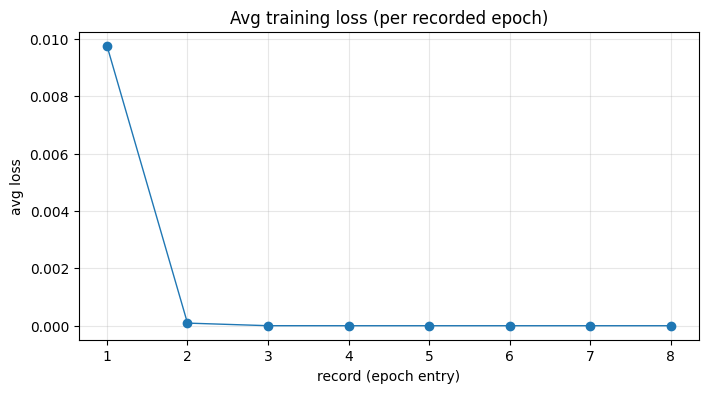

Saved: /kaggle/working/outputs/metrics_plots/avg_loss.png


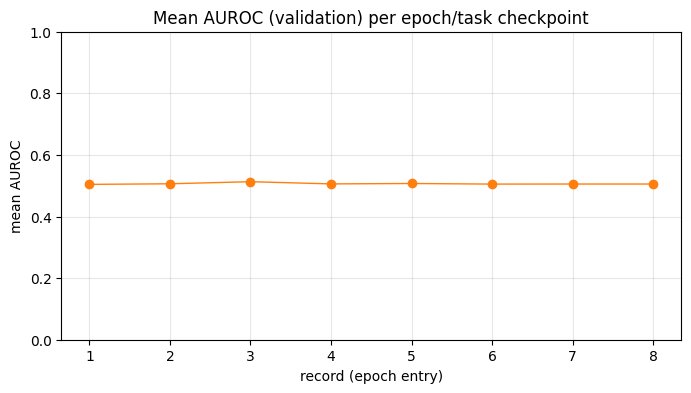

Saved: /kaggle/working/outputs/metrics_plots/mean_auc.png
Per-label AUCs not found in metrics. If you want per-label AUCs, run safe_evaluate_auroc on val_loader and save per-label AUCs to per_label_aucs.json.
No per-label AUC data available to plot. You can compute per-label AUCs using `safe_evaluate_auroc(model, val_loader, ...)` and save as per_label_aucs.json in outputs/.
Exemplar buffer size (from exemplar_buffer.json): 1200

Plots saved to: /kaggle/working/outputs/metrics_plots
['mean_auc.png', 'avg_loss.png']


In [45]:
# CELL: VISUALIZE_TRAINING_METRICS
import os, json, math, numpy as np, matplotlib.pyplot as plt
from matplotlib import ticker
OUTPUT_DIR = "/kaggle/working/outputs"
METRICS_JSON = os.path.join(OUTPUT_DIR, "training_metrics_final.json")
EXEMPLAR_JSON = os.path.join(OUTPUT_DIR, "exemplar_buffer.json")
PLOT_DIR = os.path.join(OUTPUT_DIR, "metrics_plots")
os.makedirs(PLOT_DIR, exist_ok=True)

assert os.path.exists(METRICS_JSON), f"Metrics file not found: {METRICS_JSON}"
with open(METRICS_JSON,'r') as fr:
    metrics = json.load(fr)

# normalize metrics keys/numpy -> python
def to_list(x):
    if x is None: return []
    if isinstance(x, list): return x
    try:
        return list(x)
    except:
        return [x]

task = to_list(metrics.get("task", []))
epoch = to_list(metrics.get("epoch", []))
avg_loss = to_list(metrics.get("avg_loss", []))
mean_auc = to_list(metrics.get("mean_auc", []))
skipped = to_list(metrics.get("skipped_batches", []))

# plot 1: avg_loss vs global step (or epoch index)
plt.figure(figsize=(8,4))
if len(avg_loss) == 0:
    print("No avg_loss data found in metrics.")
else:
    x = np.arange(1, len(avg_loss)+1)
    plt.plot(x, np.array(avg_loss, dtype=float), marker='o', linewidth=1)
    plt.title("Avg training loss (per recorded epoch)")
    plt.xlabel("record (epoch entry)")
    plt.ylabel("avg loss")
    plt.grid(alpha=0.3)
    fpath = os.path.join(PLOT_DIR, "avg_loss.png")
    plt.savefig(fpath, bbox_inches='tight', dpi=150)
    plt.show()
    print("Saved:", fpath)

# plot 2: mean AUROC vs recorded epoch
plt.figure(figsize=(8,4))
if len(mean_auc) == 0:
    print("No mean_auc data found in metrics.")
else:
    x = np.arange(1, len(mean_auc)+1)
    ma = np.array([float('nan') if (v is None) else float(v) for v in mean_auc], dtype=float)
    plt.plot(x, ma, marker='o', linewidth=1, color='tab:orange')
    plt.title("Mean AUROC (validation) per epoch/task checkpoint")
    plt.xlabel("record (epoch entry)")
    plt.ylabel("mean AUROC")
    plt.ylim(0.0,1.0)
    plt.grid(alpha=0.3)
    fpath = os.path.join(PLOT_DIR, "mean_auc.png")
    plt.savefig(fpath, bbox_inches='tight', dpi=150)
    plt.show()
    print("Saved:", fpath)

# If per-label AUC history is available (some setups include per-label arrays) attempt to plot final per-label AUC
# Try to read per-label values if present in metrics (e.g., metrics['label_aucs'] or metrics['aucs'])
label_aucs = None
# common shapes: metrics may store last epoch's per-label AUCs under 'aucs' or similar
if "aucs" in metrics:
    label_aucs = metrics["aucs"]
# fallback: inspect last entry if it's a dict of per-label
if label_aucs is None and isinstance(mean_auc, list) and len(mean_auc)>0:
    # try reading a per-epoch stored container: metrics may contain 'per_label' key
    for k in metrics:
        if isinstance(metrics[k], list) and len(metrics[k])==len(mean_auc):
            # skip avg_loss/mean_auc etc.
            pass

# Try to load a saved metrics JSON that may contain per-label arrays saved separately:
# We'll attempt to load 'inference_results' or 'per_label_aucs.json' nearby
per_label_path = os.path.join(OUTPUT_DIR, "per_label_aucs.json")
if os.path.exists(per_label_path):
    with open(per_label_path,'r') as fr:
        label_aucs = json.load(fr)

# If still None, try to reconstruct final label AUCs from training_metrics_final.json if stored as list under 'final_label_aucs'
if label_aucs is None and "final_label_aucs" in metrics:
    label_aucs = metrics["final_label_aucs"]

# If still none, we will attempt to compute per-label AUC from validation results file if exists:
if label_aucs is None:
    # try to read inference_results.json saved earlier (may only be predictions)
    irp = os.path.join(OUTPUT_DIR, "inference_results.json")
    if os.path.exists(irp):
        print("Found inference_results.json — but it contains predictions, not per-label AUCs.")
    else:
        print("Per-label AUCs not found in metrics. If you want per-label AUCs, run safe_evaluate_auroc on val_loader and save per-label AUCs to per_label_aucs.json.")

# If we have label_aucs (list/dict) — plot bar chart
if label_aucs is not None:
    if isinstance(label_aucs, dict):
        labels = list(label_aucs.keys())
        vals = [float(label_aucs[k]) if label_aucs[k] is not None else float('nan') for k in labels]
    else:
        # assume list
        try:
            vals = [float(x) if x is not None else float('nan') for x in label_aucs]
            labels = [f"Label {i}" for i in range(len(vals))]
        except Exception:
            labels = [f"Label {i}" for i in range(len(label_aucs))]
            vals = [float('nan')] * len(labels)
    # plot bar
    plt.figure(figsize=(10,4))
    x = np.arange(len(labels))
    plt.bar(x, vals)
    plt.xticks(x, labels, rotation=70)
    plt.ylim(0.0, 1.0)
    plt.title("Per-label AUC (final)")
    plt.ylabel("AUC")
    plt.grid(alpha=0.2, axis='y')
    fpath = os.path.join(PLOT_DIR, "per_label_auc.png")
    plt.savefig(fpath, bbox_inches='tight', dpi=150)
    plt.show()
    print("Saved:", fpath)
else:
    print("No per-label AUC data available to plot. You can compute per-label AUCs using `safe_evaluate_auroc(model, val_loader, ...)` and save as per_label_aucs.json in outputs/.")

# Optional: examine exemplar buffer size if present
if os.path.exists(EXEMPLAR_JSON):
    with open(EXEMPLAR_JSON,'r') as fr:
        ex = json.load(fr)
    n_ex = len(ex.get("paths", []))
    print(f"Exemplar buffer size (from exemplar_buffer.json): {n_ex}")
else:
    print("No exemplar_buffer.json found in outputs/.")

# Print location of saved plots
print("\nPlots saved to:", PLOT_DIR)
print(os.listdir(PLOT_DIR))


In [46]:
# CELL: EXPORT_TORCHSCRIPT_AND_ONNX
import os, torch, numpy as np
from torchvision import models
from PIL import Image

MODEL_PTH = "/kaggle/working/outputs/model_state_final.pth"
TS_OUT = "/kaggle/working/outputs/model_torchscript.pt"
ONNX_OUT = "/kaggle/working/outputs/model.onnx"
IMAGE_SIZE = 224
NUM_LABELS = 14  # change if different

assert os.path.exists(MODEL_PTH), "Model checkpoint not found."

# 1) load state dict (same architecture as training)
def get_densenet(num_labels=NUM_LABELS):
    try:
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    except Exception:
        model = models.densenet121(pretrained=True)
    in_f = model.classifier.in_features
    model.classifier = torch.nn.Linear(in_f, num_labels)
    return model

ck = torch.load(MODEL_PTH, map_location="cpu")
model = get_densenet(num_labels=ck.get("NUM_LABELS", NUM_LABELS))
model.load_state_dict(ck["model_state"])
model.eval().cpu()

# Create a dummy input (float tensor) for tracing/export
dummy = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE, dtype=torch.float32)

# TorchScript (trace) - fast and simple
try:
    traced = torch.jit.trace(model, dummy, strict=False)
    traced.save(TS_OUT)
    print("Saved TorchScript ->", TS_OUT)
except Exception as e:
    print("TorchScript trace failed:", e)

# ONNX export (dynamic batch, dynamic height/width optional)
try:
    input_names = ["input"]
    output_names = ["output"]
    dynamic_axes = {"input": {0: "batch_size", 2: "height", 3: "width"}, "output": {0: "batch_size"}}
    torch.onnx.export(model, dummy, ONNX_OUT,
                      export_params=True, opset_version=13,
                      input_names=input_names, output_names=output_names,
                      dynamic_axes=dynamic_axes, verbose=False)
    print("Saved ONNX ->", ONNX_OUT)
except Exception as e:
    print("ONNX export failed:", e)

# Quick size info
import os
for f in [TS_OUT, ONNX_OUT]:
    if os.path.exists(f):
        print(f, "size:", round(os.path.getsize(f)/(1024*1024),2), "MB")


Saved TorchScript -> /kaggle/working/outputs/model_torchscript.pt
Saved ONNX -> /kaggle/working/outputs/model.onnx
/kaggle/working/outputs/model_torchscript.pt size: 27.92 MB
/kaggle/working/outputs/model.onnx size: 26.96 MB


In [48]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 79.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.7 MB/s eta 0:00:00


In [2]:
# CELL: RUN_ONNX_RUNTIME (requires onnxruntime installed: pip install onnxruntime)
import onnxruntime as ort
import numpy as np
from PIL import Image
import os

ONNX_OUT = "/kaggle/working/outputs/model.onnx"
IMAGE_SIZE = 224
LABELS = [...]  # put your 14 labels list here or import from previous cell

def preprocess_pil(pil_img, image_size=IMAGE_SIZE):
    pil_img = pil_img.resize((image_size, image_size))
    arr = np.asarray(pil_img).astype(np.float32)/255.0
    if arr.ndim == 2:
        arr = np.stack([arr]*3, -1)
    mean = np.array([0.485,0.485,0.485], dtype=np.float32)
    std  = np.array([0.229,0.229,0.229], dtype=np.float32)
    arr = (arr - mean) / std
    arr = np.transpose(arr, (2,0,1))  # C,H,W
    arr = np.expand_dims(arr, 0)      # 1,C,H,W
    return arr.astype(np.float32)

sess = ort.InferenceSession(ONNX_OUT)
# example:
img_path = "/kaggle/input/chexpert/valid/patient64541/study1/view1_frontal.jpg"
img = Image.open(img_path).convert("RGB")
inp = preprocess_pil(img)
outputs = sess.run(None, {"input": inp})
probs = 1.0 / (1.0 + np.exp(-outputs[0]))  # sigmoid on logits
print("Top preds:", np.argsort(probs[0])[::-1][:5])


Top preds: [3 4 6 0 2]
